# V1 Evaluation

## Install dependencies

In [ ]:
for (p in c("caret", "irr", "outliers", "coin", "car", "rstatix", "RColorBrewer")) {
  if (!requireNamespace(p)) {
    install.packages(p)
  }
}

library(dplyr)
library(ggplot2)
library(reshape2)
library(tidyverse)
library(jsonlite)
library(caret)
library(irr)
library(readr)
library(outliers)
library(coin)
library(car)
library(rstatix)
library(RColorBrewer)
library(scales)

options(repr.plot.width=7.2, repr.plot.height=6)

Loading required namespace: caret

Loading required namespace: irr

Loading required namespace: outliers

Loading required namespace: coin

Loading required namespace: car

Loading required namespace: rstatix

Loading required namespace: RColorBrewer


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ tibble  3.2.1     ✔ purrr   1.0.1
✔ tidyr   1.3.0     ✔ stringr 1.4.1
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘jsonlite’


The following object is masked from ‘package:purrr’:

    flatten


Loading required package: lattice


Attaching package: ‘caret’


The following object is masked 

In [ ]:
games.howell <- function(grp, obs) {
  
  #Create combinations
  combs <- combn(unique(grp), 2)
  
  # Statistics that will be used throughout the calculations:
  # n = sample size of each group
  # groups = number of groups in data
  # Mean = means of each group sample
  # std = variance of each group sample
  n <- tapply(obs, grp, length)
  groups <- length(tapply(obs, grp, length))
  Mean <- tapply(obs, grp, mean)
  std <- tapply(obs, grp, var)
  
  statistics <- lapply(1:ncol(combs), function(x) {
    
    mean.diff <- Mean[combs[2,x]] - Mean[combs[1,x]]
    
    #t-values
    t <- abs(Mean[combs[1,x]] - Mean[combs[2,x]]) / sqrt((std[combs[1,x]] / n[combs[1,x]]) + (std[combs[2,x]] / n[combs[2,x]]))
    
    # Degrees of Freedom
    df <- (std[combs[1,x]] / n[combs[1,x]] + std[combs[2,x]] / n[combs[2,x]])^2 / # Numerator Degrees of Freedom
      ((std[combs[1,x]] / n[combs[1,x]])^2 / (n[combs[1,x]] - 1) + # Part 1 of Denominator Degrees of Freedom 
         (std[combs[2,x]] / n[combs[2,x]])^2 / (n[combs[2,x]] - 1)) # Part 2 of Denominator Degrees of Freedom
    
    #p-values
    p <- ptukey(t * sqrt(2), groups, df, lower.tail = FALSE)
    
    # Sigma standard error
    se <- sqrt(0.5 * (std[combs[1,x]] / n[combs[1,x]] + std[combs[2,x]] / n[combs[2,x]]))
    
    # Upper Confidence Limit
    upper.conf <- lapply(1:ncol(combs), function(x) {
      mean.diff + qtukey(p = 0.95, nmeans = groups, df = df) * se
    })[[1]]
    
    # Lower Confidence Limit
    lower.conf <- lapply(1:ncol(combs), function(x) {
      mean.diff - qtukey(p = 0.95, nmeans = groups, df = df) * se
    })[[1]]
    
    # Group Combinations
    grp.comb <- paste(combs[1,x], ':', combs[2,x])
    
    # Collect all statistics into list
    stats <- list(grp.comb, mean.diff, se, t, df, p, upper.conf, lower.conf)
  })
  
  # Unlist statistics collected earlier
  stats.unlisted <- lapply(statistics, function(x) {
    unlist(x)
  })
  
  # Create dataframe from flattened list
  results <- data.frame(matrix(unlist(stats.unlisted), nrow = length(stats.unlisted), byrow=TRUE))
  
  # Select columns set as factors that should be numeric and change with as.numeric
  results[c(2, 3:ncol(results))] <- round(as.numeric(as.matrix(results[c(2, 3:ncol(results))])), digits = 3)
  
  # Rename data frame columns
  colnames(results) <- c('groups', 'Mean Difference', 'Standard Error', 't', 'df', 'p', 'upper limit', 'lower limit')
  
  return(results)
}

## Load data

In [ ]:
# Load pretest data
ParticipantPretest <- read.csv(unzip("data.zip", "ParticipantPre.csv"))
ParticipantProgressPretest <- read.csv(unzip("data.zip", "ParticipantProgressPre.csv"))
AnswerPretest <- read.csv(unzip("data.zip", "AnswerPre.csv"))
FeedbackPretest <- read.csv(unzip("data.zip", "FeedbackPre.csv"))

In [ ]:
# Load actual run data
ParticipantRun <- read.csv(unzip("data.zip", "Participant.csv"))
ParticipantProgressRun <- read.csv(unzip("data.zip", "ParticipantProgress.csv"))
AnswerRun <- read.csv(unzip("data.zip", "Answer.csv"))
FeedbackRun <- read.csv(unzip("data.zip", "Feedback.csv"))

Article <- read.csv(unzip("data.zip", "Article.csv"))
Content <- read.csv(unzip("data.zip", "Content.csv"))

In [ ]:
# Load second run data
ParticipantRun2 <- read.csv(unzip("data.zip", "Participant2.csv"))
ParticipantProgressRun2 <- read.csv(unzip("data.zip", "ParticipantProgress2.csv"))
AnswerRun2 <- read.csv(unzip("data.zip", "Answer2.csv"))
FeedbackRun2 <- read.csv(unzip("data.zip", "Feedback2.csv"))

In [ ]:
# Combine into final data
Participant <- rbind(rbind(ParticipantPretest, ParticipantRun), ParticipantRun2)
ParticipantProgress <- rbind(rbind(ParticipantProgressPretest, ParticipantProgressRun), ParticipantProgressRun2)
Answer <- rbind(rbind(AnswerPretest, AnswerRun), AnswerRun2)
Feedback <- rbind(rbind(FeedbackPretest, FeedbackRun), FeedbackRun2)

## Participant (Preprocessing & Descriptive)

### Filter participants not from Prolific

In [ ]:
nrow(Participant)
Participant <- Participant %>% filter(source == "PROLIFIC")
nrow(Participant)

[1] 280

[1] 271

### Add newest progress

In [ ]:
# Join the two dataframes
df <- merge(Participant, ParticipantProgress, by.x = "id", by.y = "participantId")

# Group the data by id and sort it by createdAt in descending order
df <- df %>%
  group_by(id) %>%
  arrange(desc(createdAt.y))

# Get the first row for each group
df <- df %>%
  slice(1)

# Add to Participant
Participant <- Participant %>%
  mutate(progress = df$progress)

nrow(Participant)

[1] 271

### Filter out progress not END

In [ ]:
Participant <- Participant %>% filter(progress == "END_10")
nrow(Participant)

[1] 240

### First evaluations

In [ ]:
Participant %>% count(feedbackMechanism)

feedbackMechanism,n
<chr>,<int>
,8
COMPARISON,72
CONTROL,81
HIGHLIGHTS,79


In [ ]:
Participant %>% count(feedbackMechanism, attentionCheckFailures)

feedbackMechanism,attentionCheckFailures,n
<chr>,<int>,<int>
,0,7
,2,1
COMPARISON,0,70
COMPARISON,1,2
CONTROL,0,76
CONTROL,1,5
HIGHLIGHTS,0,74
HIGHLIGHTS,1,5


In [ ]:
Participant %>% count(feedbackMechanism, dataUsableForResearch)

feedbackMechanism,dataUsableForResearch,n
<chr>,<int>,<int>
,0,8
COMPARISON,0,6
COMPARISON,1,66
CONTROL,0,12
CONTROL,1,69
HIGHLIGHTS,0,8
HIGHLIGHTS,1,71


In [ ]:
Participant %>% count(feedbackMechanism, dataProcessingConsent)

feedbackMechanism,dataProcessingConsent,n
<chr>,<int>,<int>
,0,5
,1,3
COMPARISON,1,72
CONTROL,1,81
HIGHLIGHTS,1,79


### Filter out data not usable

In [ ]:
Participant <- Participant %>% filter(dataUsableForResearch == 1)
nrow(Participant)

[1] 206

### Filter out data processing not agreed

In [ ]:
Participant <- Participant %>% filter(dataProcessingConsent == 1)
nrow(Participant)

[1] 206

### Mechanism distribution after filtering

In [ ]:
MechanismDistribution <- Participant %>% count(feedbackMechanism)
MechanismDistribution

feedbackMechanism,n
<chr>,<int>
COMPARISON,66
CONTROL,69
HIGHLIGHTS,71


## Participant Progress (Descriptive)

### Preprocessing

In [ ]:
# Filter out rows without a matching Participant
ParticipantProgress <- semi_join(ParticipantProgress, Participant, by = c("participantId" = "id"))

# Calculate the total time for each participant
ParticipantTotalTimes <- ParticipantProgress %>%
  group_by(participantId) %>%
  summarise(
    totalTime = max(createdAt) - min(createdAt)
  )

ParticipantArticleTimes <- ParticipantProgress %>%
  filter(progress %in% c("ARTICLES_08", "TRUST_CHECK_09")) %>%
  group_by(participantId) %>%
  summarise(
    articleTime = max(createdAt) - min(createdAt)
  )

### Plots

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


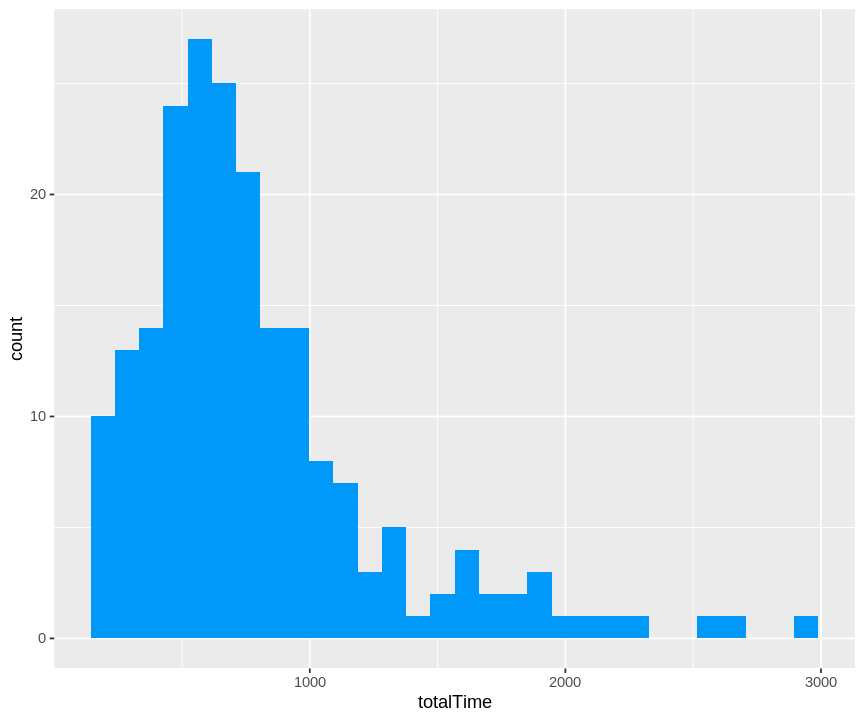

In [ ]:
# Total times
ggplot(ParticipantTotalTimes, aes(x = totalTime)) +
  geom_histogram(fill = "#0099f9")

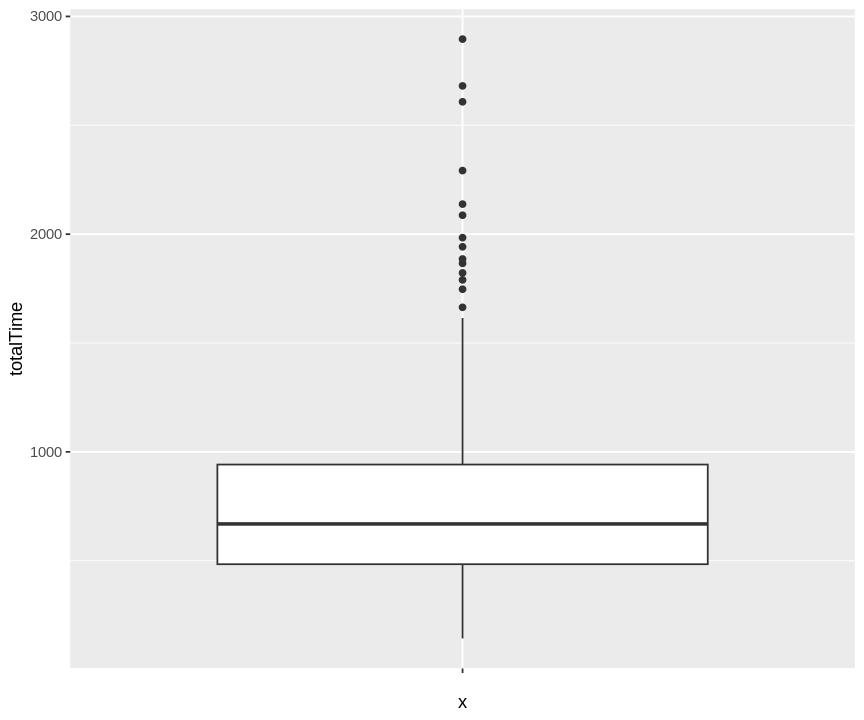

In [ ]:
ggplot(ParticipantTotalTimes, aes(x = "", y = totalTime)) +
  geom_boxplot()

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


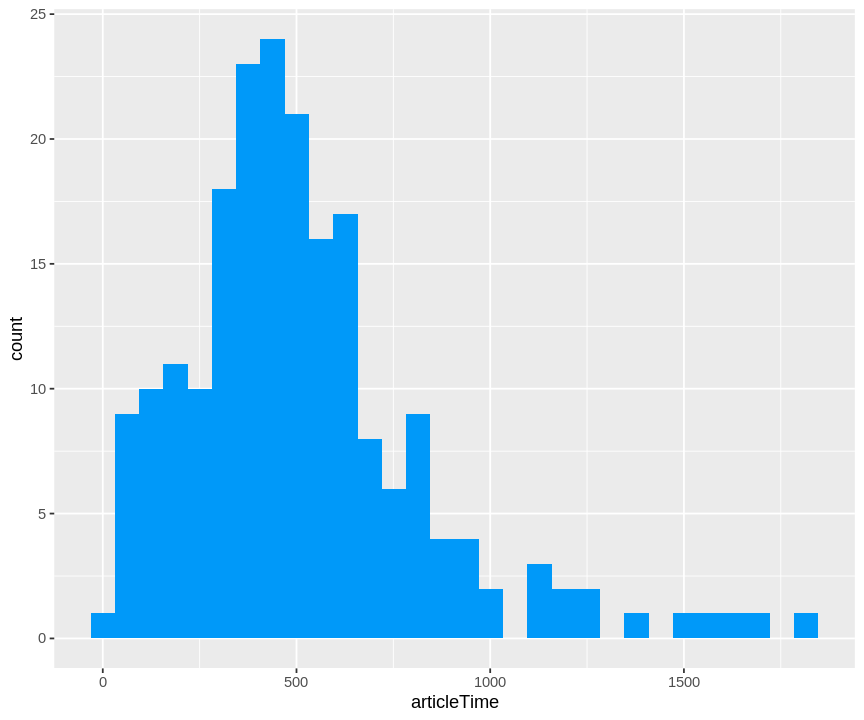

In [ ]:
# Time in articles
ggplot(ParticipantArticleTimes, aes(x = articleTime)) +
  geom_histogram(fill = "#0099f9")

## Answer (Descriptive)

### Preprocessing

In [ ]:
# Filter out rows without a matching Participant
Answer <- semi_join(Answer, Participant, by = c("participantId" = "id"))

# Load the answers as a list()
Answer$newsOutlets <- lapply(Answer$newsOutlets, function(x) fromJSON(x, simplifyVector = FALSE))

# Unnest the newsOutlets into a new row for each value
AnswerNewsOutlets <- Answer %>%
  unnest(newsOutlets)

### Plots

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


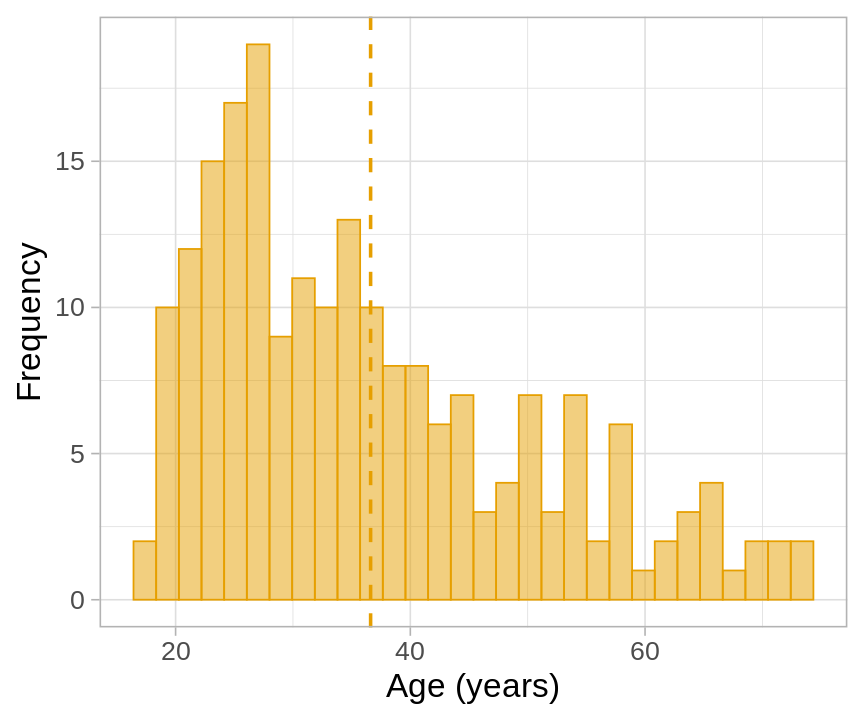

In [ ]:
# Descriptive statistics
ggplot(Answer, aes(x = age)) +
  theme_light(base_size = 20) +
  geom_histogram(color = "#E69F00", fill = "#E69F00", alpha=0.5) +
  geom_vline(aes(xintercept=mean(age)), color="#E69F00", linetype="dashed", size=1) +
  labs(x="Age (years)", y = "Frequency")
ggsave('/content/plots/answer-age.pdf', width=7.2, height=6)

In [ ]:
Answer %>% count(gender)

gender,n
<chr>,<int>
Female,104
I prefer not to say,1
Male,99
Other,2


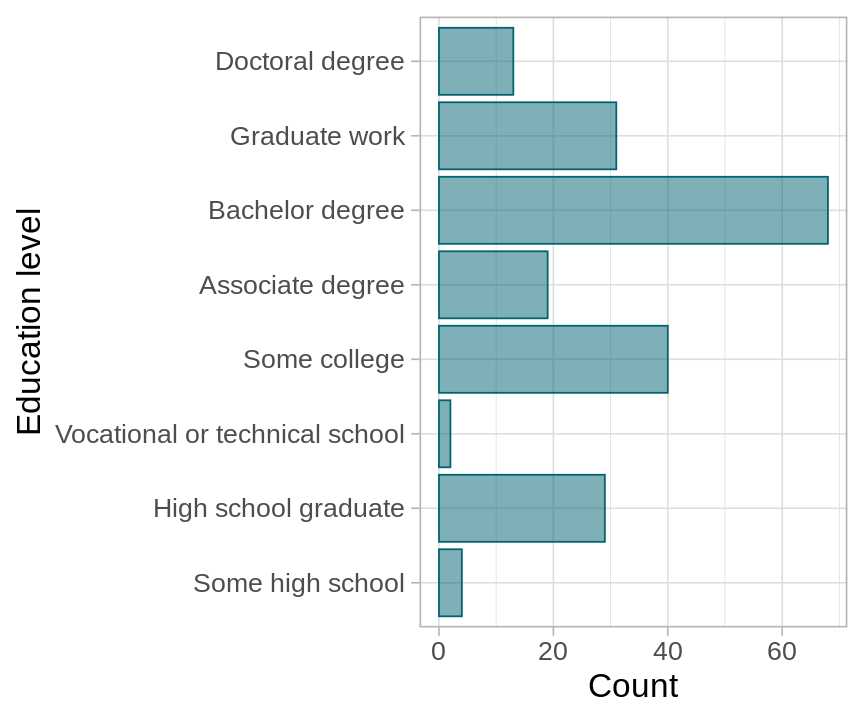

In [ ]:
Answer$educationLevel <- gsub("Bachelor’s degree", "Bachelor degree", Answer$educationLevel)
positions <- c("Some high school", "High school graduate", "Vocational or technical school", "Some college", "Associate degree", "Bachelor degree", "Graduate work", "Doctoral degree")
ggplot(Answer, aes(x = educationLevel)) +
  theme_light(base_size = 20) +
  geom_bar(fill = "#006370", color = "#006370", alpha=0.5) +
  scale_x_discrete(limits = positions) +
  coord_flip() +
  labs(x="Education level", y = "Count")
ggsave('/content/plots/answer-education.pdf', width=7.2, height=6)

In [ ]:
Answer %>% count(englishLevel)

englishLevel,n
<chr>,<int>
Advanced,196
Beginner,1
Intermediate,9


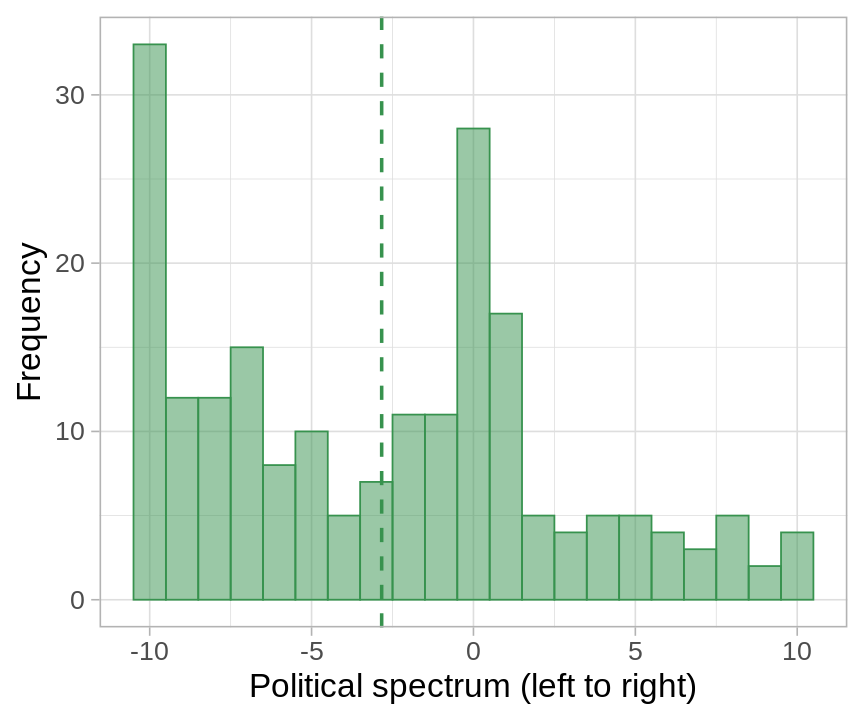

In [ ]:
ggplot(Answer, aes(x = politicalSpectrum)) +
  theme_light(base_size = 20) +
  geom_histogram(bins=21,color = "#37924E", fill = "#37924E", alpha=0.5) +
  geom_vline(aes(xintercept=mean(politicalSpectrum)), color="#37924E", linetype="dashed", size=1) +
  labs(x="Political spectrum (left to right)", y = "Frequency")
ggsave('/content/plots/answer-political.pdf', width=7.2, height=6)

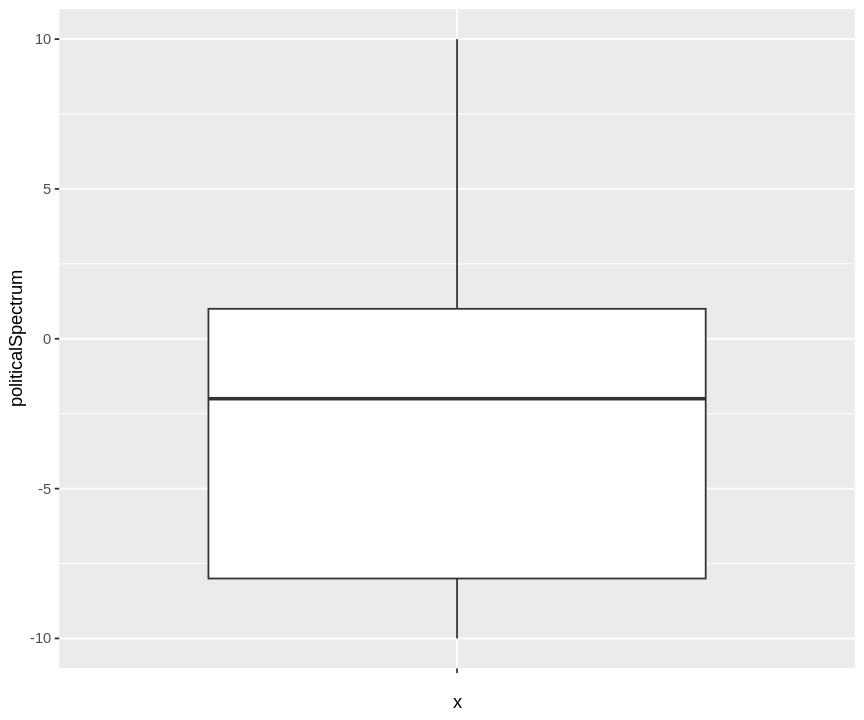

In [ ]:
ggplot(Answer, aes(x = "", y = politicalSpectrum)) +
  geom_boxplot()

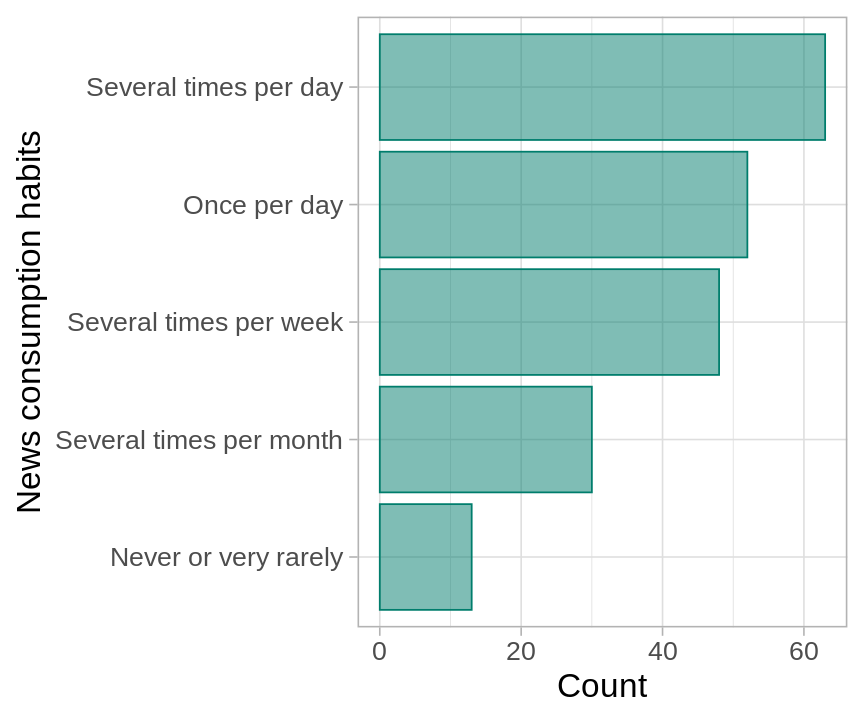

In [ ]:
positions <- c("Never or very rarely", "Several times per month", "Several times per week", "Once per day", "Several times per day")
ggplot(Answer, aes(x = newsConsumption)) +
  theme_light(base_size = 20) +
  geom_bar(stat  ="count", fill = "#007D6C", color = "#007D6C", alpha=0.5) +
  scale_x_discrete(limits = positions) +
  coord_flip() +
  labs(x="News consumption habits", y = "Count")
ggsave('/content/plots/answer-news.pdf', width=7.2, height=6)

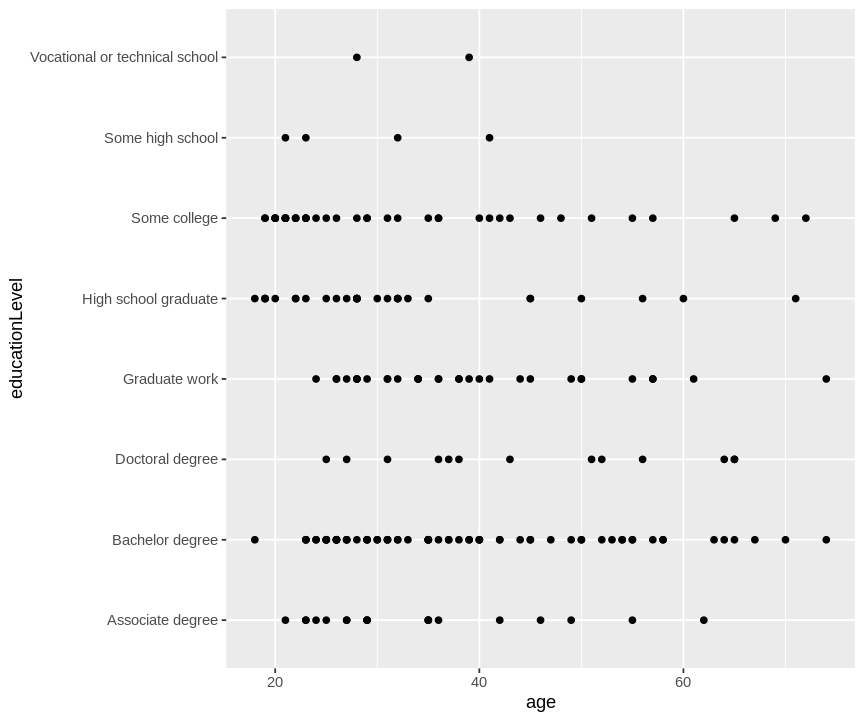

In [ ]:
ggplot(Answer, aes(x = age, y = educationLevel)) +
  geom_point()

### Preprocess news outlets and assign AllSides media bias rating

In [ ]:
num_participants_by_spectrum <-
  Answer %>%
  group_by(politicalSpectrum) %>%
  count(participantId) %>%
  group_by(politicalSpectrum) %>%
  summarize(numParticipants = n())

news_outlet_by_spectrum <-
  AnswerNewsOutlets %>%
  group_by(politicalSpectrum, newsOutlets) %>%
  count()

news_outlet_by_spectrum <- left_join(news_outlet_by_spectrum, num_participants_by_spectrum, by = "politicalSpectrum")

news_outlet_by_spectrum <-
  news_outlet_by_spectrum %>%
  mutate(relOutletFollowers = n/numParticipants, newsOutlets = as.character(newsOutlets))

news_outlet_by_spectrum <- news_outlet_by_spectrum %>% separate_rows(newsOutlets, sep = ", ")

news_outlet_by_spectrum$newsOutlets <- gsub("^bbc$", "BBC News", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^BCC$", "BBC News", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^BBC$", "BBC News", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^Breitbart$", "Breitbart News", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^Fox Local$", "Fox Online News", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^Fox News$", "Fox Online News", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^local news$", "local", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^Social media - boots on the ground reporting. The above choices are all compromised$", "Social media", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^also Twitter & Reddit$", "Social media", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^Reddit$", "Social media", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^Twitter$", "Social media", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^Used to be twitter$", "Social media", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^BuzzFeed$", "BuzzFeed News", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^CNN$", "CNN (Web News)", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^Huffington Post$", "HuffPost", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^New York Times$", "New York Times - News", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^The Wall Street Journal$", "Wall Street Journal - News", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^The Washington Post$", "Washington Post", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^The Financial Times$", "Financial Times", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^Time magazine$", "Time Magazine", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^USA Today$", "USA TODAY", news_outlet_by_spectrum$newsOutlets)
news_outlet_by_spectrum$newsOutlets <- gsub("^PBS Newshour$", "PBS NewsHour", news_outlet_by_spectrum$newsOutlets)

sort(unique(news_outlet_by_spectrum$newsOutlets))

[1] "ABC News"                   "AP"                        
 [3] "BBC News"                   "Breitbart News"            
 [5] "Business Insider"           "BuzzFeed News"             
 [7] "CBS News"                   "CNN (Web News)"            
 [9] "corriere della sera"        "Counter Punch"             
[11] "Daily Kos"                  "Financial Times"           
[13] "Fox Online News"            "Free Speech TV"            
[15] "Haystack News"              "HuffPost"                  
[17] "kcrw"                       "ktla"                      
[19] "local"                      "Mint Press"                
[21] "MSNBC"                      "New York Post"             
[23] "New York Times - News"      "news.ycombinator.com"      
[25] "NHK"                        "NPR"                       
[27] "PBS NewsHour"               "Reuters"                   
[29] "SmartNews News Aggregator"  "Social media"              
[31] "The Economist"              "The Federalist"            
[33] "The Guardian"               "Time Magazine"             
[35] "tmz"                        "TYT"                       
[37] "Univision"                  "USA TODAY"                 
[39] "Vice"                       "Vox"                       
[41] "Wall Street Journal - News" "Washington Post"

In [ ]:
allsides_data <- readr::read_csv("https://raw.githubusercontent.com/favstats/AllSideR/master/data/allsides_data.csv")

Rows: 547 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): news_source, rating, type, url, editorial_review, confidence_level...
dbl  (7): rating_num, agree, disagree, perc_agree, blind_survey, third_party...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [ ]:
news_outlet_by_spectrum_with_allsides <- merge(news_outlet_by_spectrum, allsides_data[, c("news_source", "rating_num")], by.x = "newsOutlets", by.y = "news_source", all.x = TRUE)

### Plot news outlets results

Warning message:
“Removed 22 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 22 rows containing missing values (`geom_point()`).”


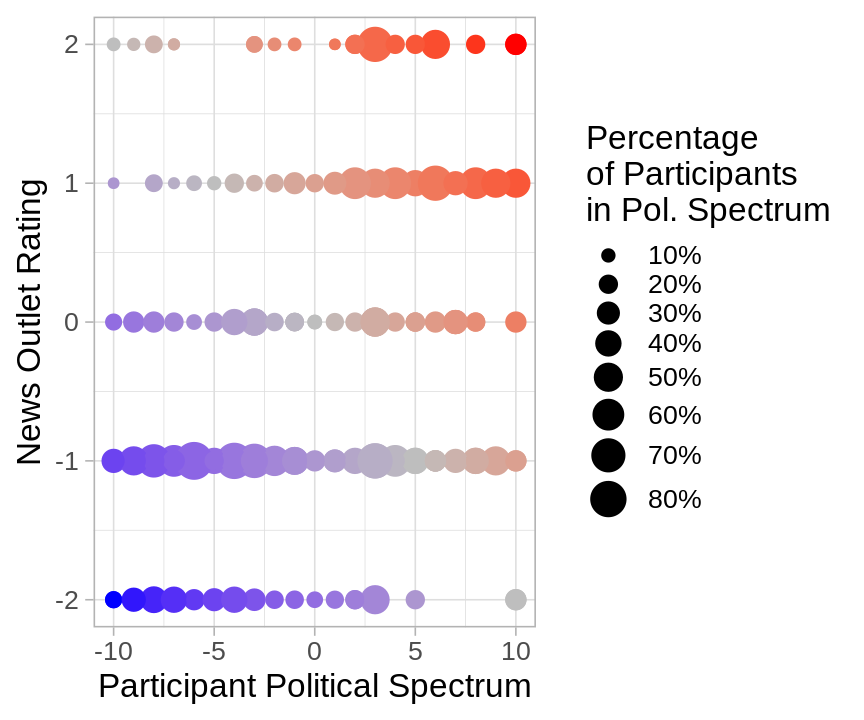

In [ ]:
ggplot(data= news_outlet_by_spectrum_with_allsides, aes(x = politicalSpectrum, y=rescale(rating_num, to=c(-2,2)), size=relOutletFollowers)) +
  theme_light(base_size = 20) +
  geom_point(aes(color = (rescale(politicalSpectrum, to=c(0,1)) + rescale(rating_num, to=c(0,1)))/2)) +
  scale_size_area(max_size = 10, name = "Percentage\nof Participants\nin Pol. Spectrum",
                  breaks = c(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8), 
                  labels = c("10%", "20%", "30%", "40%", "50%", "60%", "70%", "80%")) +
  xlab("Participant Political Spectrum") +
  ylab("News Outlet Rating") +
  scale_color_gradient2(low = "blue", mid = "gray", high = "red", midpoint = 0.5, ) +
  guides(color = FALSE)
ggsave('/content/plots/political-followers.pdf', width=10, height=6)

## Content & Article (Descriptive)

### Preprocessing

In [ ]:
calculate_performance <- function(pred, true) {
  # Convert pred and true to factors
  pred <- as.factor(pred)
  true <- as.factor(true)
  
  # Set levels of pred and true to be the same
  levels(pred) <- levels(true)
  
  # Calculate and return confusion matrix
  confusionMatrix(pred, true, mode = "everything", positive="1")
}

In [ ]:
ContentWithArticle <- merge(Article, Content, by.x = "id", by.y = "articleId")
ContentWithArticle <- ContentWithArticle %>% filter(htmlType == "SPAN")

# Left
ContentArticle1 <- ContentWithArticle %>% filter(indexInStudy == 0)
# Right
ContentArticle2 <- ContentWithArticle %>% filter(indexInStudy == 1)

### Plots

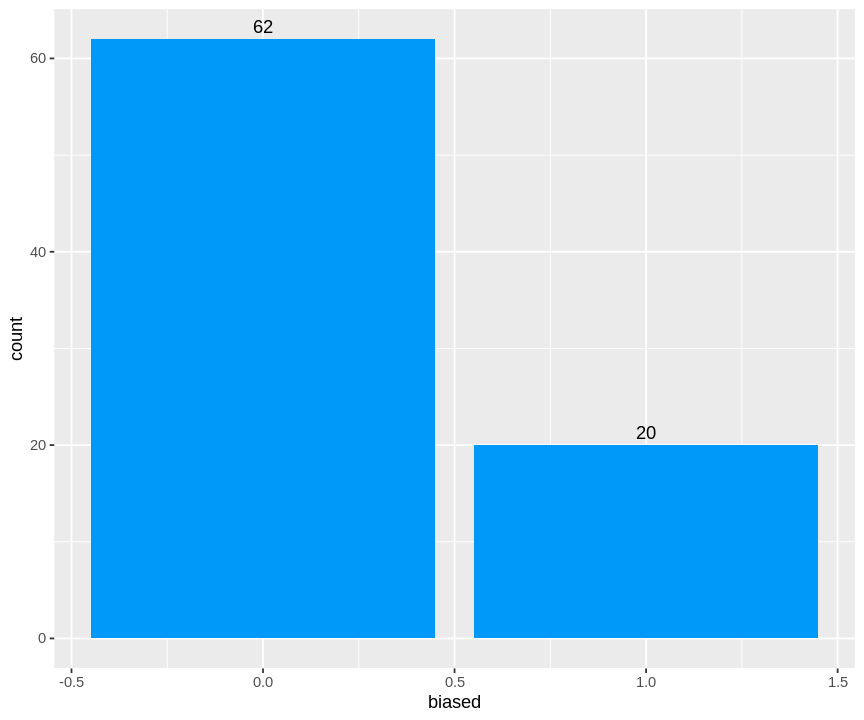

In [ ]:
ggplot(ContentWithArticle, aes(x = biased)) +
  geom_bar(fill = "#0099f9") + 
  geom_text(
     aes(label=after_stat(count)),
     stat='count',
     position = "stack", 
     vjust = -0.5
 )

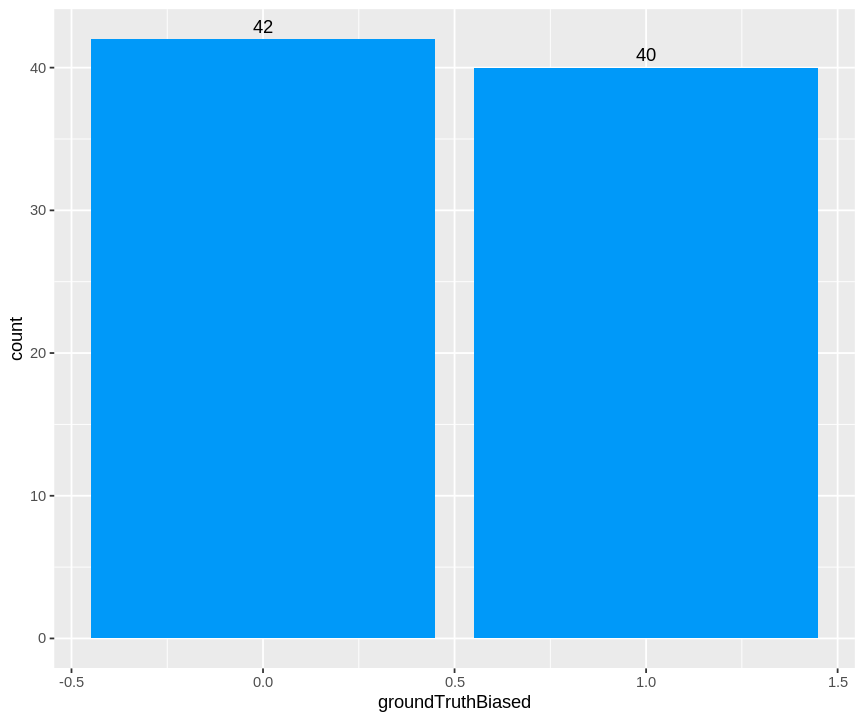

In [ ]:
ggplot(ContentWithArticle, aes(x = groundTruthBiased)) +
  geom_bar(fill = "#0099f9") + 
  geom_text(
     aes(label=after_stat(count)),
     stat='count',
     position = "stack", 
     vjust = -0.5
 )

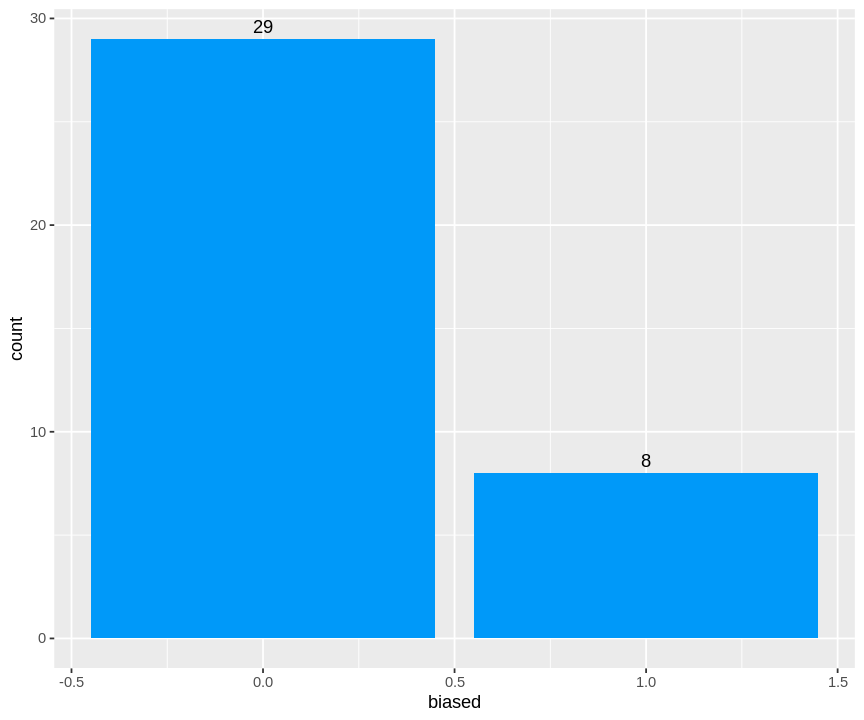

In [ ]:
ggplot(ContentArticle1, aes(x = biased)) +
  geom_bar(fill = "#0099f9") + 
  geom_text(
     aes(label=after_stat(count)),
     stat='count',
     position = "stack", 
     vjust = -0.5
 )

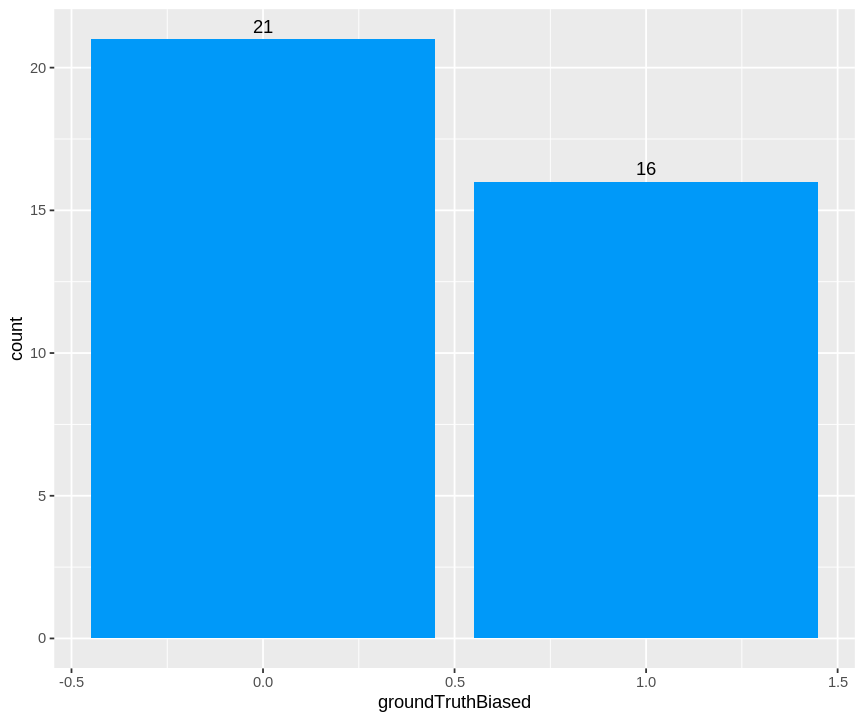

In [ ]:
ggplot(ContentArticle1, aes(x = groundTruthBiased)) +
  geom_bar(fill = "#0099f9") + 
  geom_text(
     aes(label=after_stat(count)),
     stat='count',
     position = "stack", 
     vjust = -0.5
 )

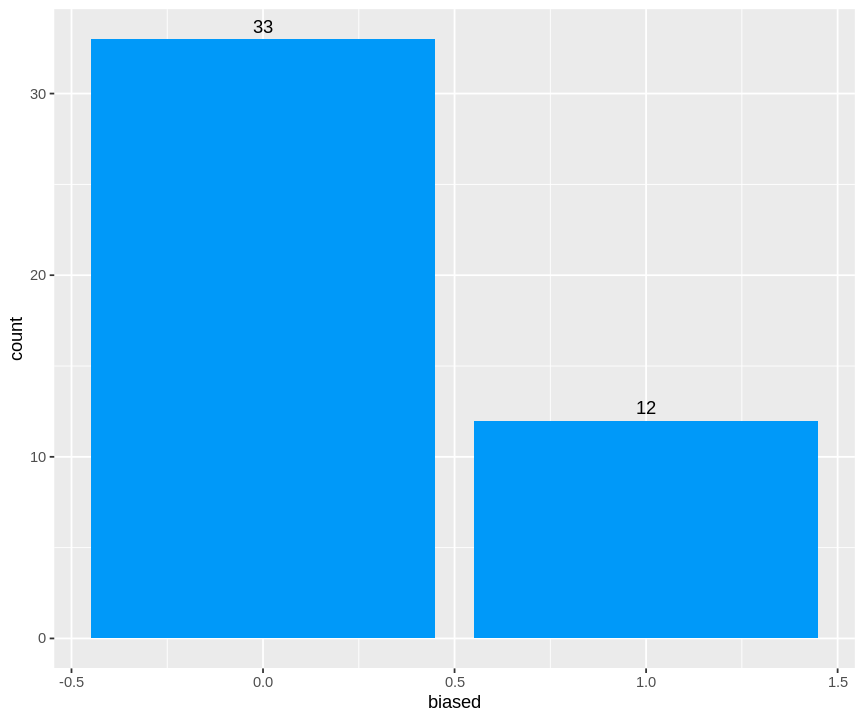

In [ ]:
ggplot(ContentArticle2, aes(x = biased)) +
  geom_bar(fill = "#0099f9") + 
  geom_text(
     aes(label=after_stat(count)),
     stat='count',
     position = "stack", 
     vjust = -0.5
 )

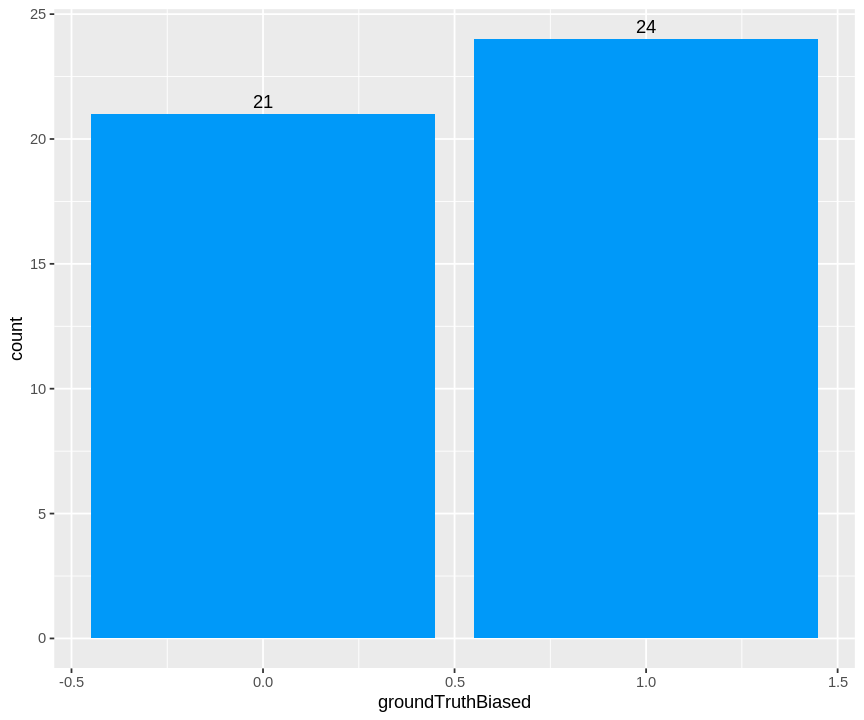

In [ ]:
ggplot(ContentArticle2, aes(x = groundTruthBiased)) +
  geom_bar(fill = "#0099f9") + 
  geom_text(
     aes(label=after_stat(count)),
     stat='count',
     position = "stack", 
     vjust = -0.5
 )

### Classifier performance

In [ ]:
calculate_performance(ContentWithArticle$biased, ContentWithArticle$groundTruthBiased)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 37 25
         1  5 15
                                          
               Accuracy : 0.6341          
                 95% CI : (0.5205, 0.7378)
    No Information Rate : 0.5122          
    P-Value [Acc > NIR] : 0.0174560       
                                          
                  Kappa : 0.259           
                                          
 Mcnemar's Test P-Value : 0.0005226       
                                          
            Sensitivity : 0.3750          
            Specificity : 0.8810          
         Pos Pred Value : 0.7500          
         Neg Pred Value : 0.5968          
              Precision : 0.7500          
                 Recall : 0.3750          
                     F1 : 0.5000          
             Prevalence : 0.4878          
         Detection Rate : 0.1829          
   Detection Prevalence : 0.2439          
      Balanced Accuracy : 0.6280    

In [ ]:
calculate_performance(ContentArticle1$biased, ContentArticle1$groundTruthBiased)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 18 11
         1  3  5
                                          
               Accuracy : 0.6216          
                 95% CI : (0.4476, 0.7754)
    No Information Rate : 0.5676          
    P-Value [Acc > NIR] : 0.31166         
                                          
                  Kappa : 0.1804          
                                          
 Mcnemar's Test P-Value : 0.06137         
                                          
            Sensitivity : 0.3125          
            Specificity : 0.8571          
         Pos Pred Value : 0.6250          
         Neg Pred Value : 0.6207          
              Precision : 0.6250          
                 Recall : 0.3125          
                     F1 : 0.4167          
             Prevalence : 0.4324          
         Detection Rate : 0.1351          
   Detection Prevalence : 0.2162          
      Balanced Accuracy : 0.5848    

In [ ]:
calculate_performance(ContentArticle2$biased, ContentArticle2$groundTruthBiased)

Confusion Matrix and Statistics

          Reference
Prediction  0  1
         0 19 14
         1  2 10
                                          
               Accuracy : 0.6444          
                 95% CI : (0.4878, 0.7813)
    No Information Rate : 0.5333          
    P-Value [Acc > NIR] : 0.08860         
                                          
                  Kappa : 0.3103          
                                          
 Mcnemar's Test P-Value : 0.00596         
                                          
            Sensitivity : 0.4167          
            Specificity : 0.9048          
         Pos Pred Value : 0.8333          
         Neg Pred Value : 0.5758          
              Precision : 0.8333          
                 Recall : 0.4167          
                     F1 : 0.5556          
             Prevalence : 0.5333          
         Detection Rate : 0.2222          
   Detection Prevalence : 0.2667          
      Balanced Accuracy : 0.6607    

## Feedback (Preprocessing & Descriptive)

### Preprocessing

In [ ]:
nrow(Feedback)

[1] 17680

In [ ]:
# Filter out rows without a matching Participant
Feedback <- semi_join(Feedback, Participant, by = c("participantId" = "id"))

nrow(Feedback)

[1] 15085

In [ ]:
# Add data
Feedback <- merge(Feedback, Content[ , c("id", "indexInArticle", "biased", "groundTruthBiased", "articleId")], by.x = "contentId", by.y = "id") %>% 
  rename(
    biasedParticipant = biased.x,
    biasedClassifier = biased.y
  )

Feedback <- merge(Feedback, Participant[ , c("id", "feedbackMechanism")], by.x = "participantId", by.y = "id")

# All CONTROL feedback has basedOnClassifier set to 1 instead of 0
# This was an accidental error, but it's easy to fix
Feedback <- Feedback %>% mutate(basedOnClassifier = ifelse(feedbackMechanism == "CONTROL", 0, basedOnClassifier))

Feedback

participantId,contentId,id,biasedParticipant,basedOnClassifier,createdAt,indexInArticle,biasedClassifier,groundTruthBiased,articleId,feedbackMechanism
<chr>,<chr>,<chr>,<int>,<dbl>,<int>,<int>,<int>,<int>,<chr>,<chr>
02cafdfa-55a1-454a-a613-ea7598ffaa75,65504277-7870-4cd6-b918-47fb9b7a0770,7ebc731c-419f-442d-9208-93c06c05c1a7,0,1,1671677464,22,0,0,225c5df6-aa25-4c29-831a-ee489a5994e2,HIGHLIGHTS
02cafdfa-55a1-454a-a613-ea7598ffaa75,abfb7fa7-0544-43ca-845b-52a95a28e732,4ec2059d-4a6f-446a-8295-7a0d42ea62d3,1,1,1671677130,18,0,0,529914ec-2e3e-4b2d-b702-df99e4c720c6,HIGHLIGHTS
02cafdfa-55a1-454a-a613-ea7598ffaa75,b6294803-ab4d-4135-b2f3-60354cb2570c,24eb8928-1791-435c-93f6-2495d5495669,1,1,1671677231,35,1,1,529914ec-2e3e-4b2d-b702-df99e4c720c6,HIGHLIGHTS
02cafdfa-55a1-454a-a613-ea7598ffaa75,a0971bed-bfd0-4dd0-a901-e961327e29c9,cbf3ee3a-3f7e-4202-9303-534e7ccb0f70,0,1,1671676862,3,0,0,529914ec-2e3e-4b2d-b702-df99e4c720c6,HIGHLIGHTS
02cafdfa-55a1-454a-a613-ea7598ffaa75,6a4d71b0-6762-4906-8b79-9295e09dc6ec,760e19e6-e249-452c-a03b-bb8e0f44467c,0,1,1671677275,45,0,0,529914ec-2e3e-4b2d-b702-df99e4c720c6,HIGHLIGHTS
02cafdfa-55a1-454a-a613-ea7598ffaa75,bf64cdf6-6f11-4e33-b6df-bc8c3d90526c,95108c31-060f-455a-9c84-c435c74f3c1f,1,1,1671677632,43,1,1,225c5df6-aa25-4c29-831a-ee489a5994e2,HIGHLIGHTS
02cafdfa-55a1-454a-a613-ea7598ffaa75,35329e69-9648-477d-aa7f-e90967b5e792,6ef6a38b-14ee-4891-9b55-d91609d3c0fa,0,1,1671677138,19,0,0,529914ec-2e3e-4b2d-b702-df99e4c720c6,HIGHLIGHTS
02cafdfa-55a1-454a-a613-ea7598ffaa75,7425a235-928a-4a39-aa94-9dab6932c2e7,3efc24d7-9435-4b7a-abdf-cb13dc431121,0,1,1671677281,46,0,1,529914ec-2e3e-4b2d-b702-df99e4c720c6,HIGHLIGHTS
02cafdfa-55a1-454a-a613-ea7598ffaa75,fab8cad1-aa5c-4de3-aa17-9a34bc1c8a47,089c459e-1da8-442e-bbfa-08c70ded79b3,0,1,1671677372,10,0,0,225c5df6-aa25-4c29-831a-ee489a5994e2,HIGHLIGHTS


In [ ]:
# Add matchesClassifier, matchesGroundTruth
Feedback$matchesClassifier <- ifelse(Feedback$biasedParticipant == Feedback$biasedClassifier, 1, 0)
Feedback$matchesGroundTruth <- ifelse(Feedback$biasedParticipant == Feedback$groundTruthBiased, 1, 0)

FeedbackOnlyMechanisms <- Feedback %>% filter(feedbackMechanism != "CONTROL")
FeedbackOnlyHighlights <- Feedback %>% filter(feedbackMechanism == "HIGHLIGHTS")
FeedbackOnlyComparison <- Feedback %>% filter(feedbackMechanism == "COMPARISON")
FeedbackOnlyControl <- Feedback %>% filter(feedbackMechanism == "CONTROL")

### Descriptive evaluation

In [ ]:
# Join the two dataframes on the id and contentId columns
df_merged <- merge(Content, Feedback, by.x = "id", by.y = "contentId")

# Group the dataframe by id and count the number of distinct participantId values
FeedbackCounts <- df_merged %>% group_by(id, feedbackMechanism) %>% summarize(n_users = n_distinct(participantId))
FeedbackCountsTotal <- FeedbackCounts %>% group_by(feedbackMechanism) %>% summarise(totalFeedback = sum(n_users))
FeedbackCountsTotal

`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.


feedbackMechanism,totalFeedback
<chr>,<int>
COMPARISON,4484
CONTROL,5037
HIGHLIGHTS,5564


`summarise()` has grouped output by 'feedbackMechanism'. You can override using
the `.groups` argument.


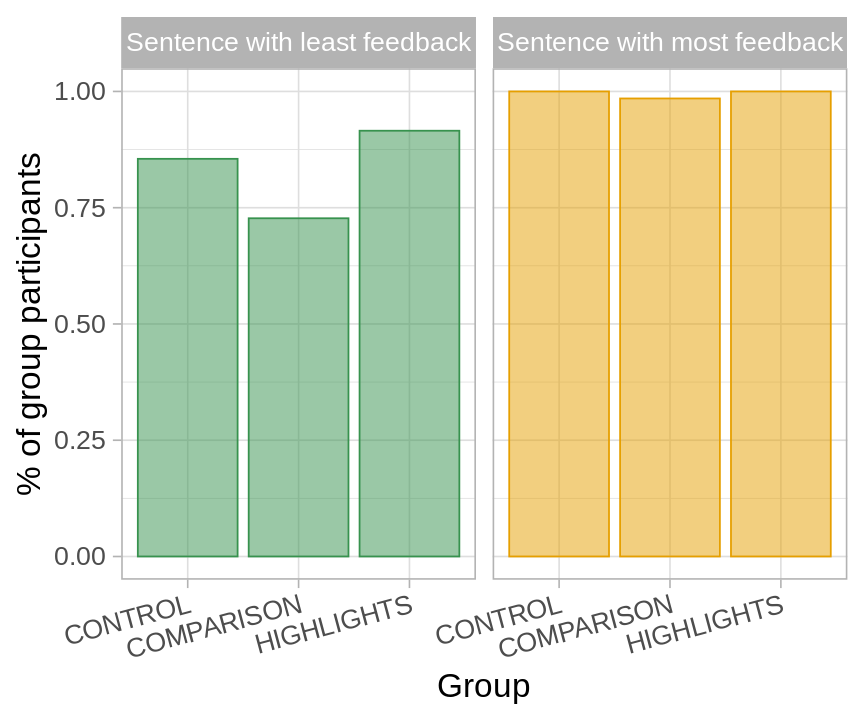

In [ ]:
# What percentage of participants annotated the least and most annotated sentences, per group
FeedbackCounts %>% 
      merge(MechanismDistribution, by = "feedbackMechanism") %>% 
      group_by(feedbackMechanism, n) %>% 
      summarise(min = min(n_users), max = max(n_users)) %>% 
      summarise(feedbackMechanism = feedbackMechanism, min_rel = min/n, max_rel=max/n) %>%
      pivot_longer(!feedbackMechanism, names_to = "variable", values_to = "value") %>%
      mutate(variable = factor(variable, levels = c("min_rel", "max_rel"))) %>%
      mutate(feedbackMechanism = factor(feedbackMechanism, levels = c("CONTROL", "COMPARISON", "HIGHLIGHTS"))) %>%

ggplot(., aes(x = feedbackMechanism, y = value)) +
  geom_bar(stat="identity", alpha=0.5, show.legend = FALSE, aes(fill = variable, color = variable)) +
  facet_grid(. ~ variable, labeller = as_labeller(c(max_rel = "Sentence with most feedback", min_rel = "Sentence with least feedback"))) +
  scale_x_discrete(guide = guide_axis(angle=15)) +
  theme_light(base_size = 20) +
  scale_fill_manual(values=c("#37924E", "#E69F00")) + 
  scale_color_manual(values=c("#37924E", "#E69F00")) +
  labs(x="Group", y = "% of group participants")
ggsave('/content/plots/feedback-leastmost.pdf', width=7.2, height=6)

In [ ]:
# Mean feedback per participant
MeanFeedbackPerMechanism <- Feedback %>% merge(MechanismDistribution, by = "feedbackMechanism") %>% group_by(feedbackMechanism, n) %>% summarise(totalFeedback = n()) %>% group_by(feedbackMechanism) %>% summarise(meanFeedback = totalFeedback/n)
MeanFeedbackPerMechanism

`summarise()` has grouped output by 'feedbackMechanism'. You can override using
the `.groups` argument.


feedbackMechanism,meanFeedback
<chr>,<dbl>
COMPARISON,67.93939
CONTROL,73.00000
HIGHLIGHTS,78.36620


`summarise()` has grouped output by 'feedbackMechanism'. You can override using
the `.groups` argument.
`summarise()` has grouped output by 'feedbackMechanism'. You can override using
the `.groups` argument.


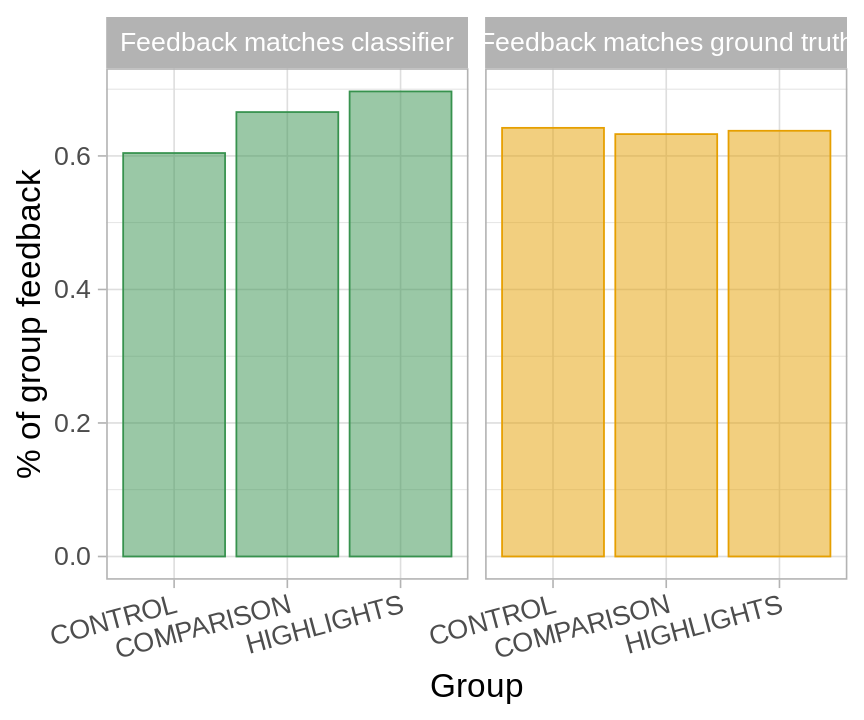

In [ ]:
# Percentage of feedback that matches classifier
FMCL <- Feedback %>% 
  filter(matchesClassifier == 1) %>%
  merge(FeedbackCountsTotal, by = "feedbackMechanism") %>%
  group_by(feedbackMechanism, totalFeedback) %>% 
  summarise(total=n()) %>%
  group_by(feedbackMechanism) %>%
  summarise(meanClassifier=total/totalFeedback)

# Percentage of feedback that matches ground truth (is correct)
FMGT <- Feedback %>% 
  filter(matchesGroundTruth == 1) %>%
  merge(FeedbackCountsTotal, by = "feedbackMechanism") %>%
  group_by(feedbackMechanism, totalFeedback) %>% 
  summarise(total=n()) %>%
  group_by(feedbackMechanism) %>%
  summarise(meanGroundTruth=total/totalFeedback)

FMGT %>% merge(FMCL, by = "feedbackMechanism") %>%
    pivot_longer(!feedbackMechanism, names_to = "variable", values_to = "value") %>%
    mutate(variable = factor(variable, levels = c("meanClassifier", "meanGroundTruth"))) %>%
    mutate(feedbackMechanism = factor(feedbackMechanism, levels = c("CONTROL", "COMPARISON", "HIGHLIGHTS"))) %>%

ggplot(., aes(x = feedbackMechanism, y = value)) +
  geom_bar(stat="identity", alpha=0.5, show.legend = FALSE, aes(fill = variable, color = variable)) +
  facet_grid(. ~ variable, labeller = as_labeller(c(meanClassifier = "Feedback matches classifier", meanGroundTruth = "Feedback matches ground truth"))) +
  scale_x_discrete(guide = guide_axis(angle=15)) +
  theme_light(base_size = 20) +
  scale_fill_manual(values=c("#37924E", "#E69F00")) + 
  scale_color_manual(values=c("#37924E", "#E69F00")) +
  labs(x="Group", y = "% of group feedback")
ggsave('/content/plots/feedback-matches.pdf', width=7.5, height=6)

In [ ]:
# Total feedback given by valid participants
Feedback %>% count(feedbackMechanism)

feedbackMechanism,n
<chr>,<int>
COMPARISON,4484
CONTROL,5037
HIGHLIGHTS,5564


## Feedback (Inferential)


### F1 scores of participants

In [ ]:
# Doing this just for fun, there's no significant meaning behind this
calculate_performance(FeedbackOnlyHighlights$biasedParticipant, FeedbackOnlyHighlights$groundTruthBiased)
calculate_performance(FeedbackOnlyComparison$biasedParticipant, FeedbackOnlyComparison$groundTruthBiased)
calculate_performance(FeedbackOnlyControl$biasedParticipant, FeedbackOnlyControl$groundTruthBiased)

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 2095 1265
         1  751 1453
                                          
               Accuracy : 0.6377          
                 95% CI : (0.6249, 0.6503)
    No Information Rate : 0.5115          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2719          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5346          
            Specificity : 0.7361          
         Pos Pred Value : 0.6593          
         Neg Pred Value : 0.6235          
              Precision : 0.6593          
                 Recall : 0.5346          
                     F1 : 0.5904          
             Prevalence : 0.4885          
         Detection Rate : 0.2611          
   Detection Prevalence : 0.3961          
      Balanced Accuracy 

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1652 1009
         1  638 1185
                                          
               Accuracy : 0.6327          
                 95% CI : (0.6184, 0.6468)
    No Information Rate : 0.5107          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2624          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5401          
            Specificity : 0.7214          
         Pos Pred Value : 0.6500          
         Neg Pred Value : 0.6208          
              Precision : 0.6500          
                 Recall : 0.5401          
                     F1 : 0.5900          
             Prevalence : 0.4893          
         Detection Rate : 0.2643          
   Detection Prevalence : 0.4066          
      Balanced Accuracy 

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1913 1146
         1  657 1321
                                          
               Accuracy : 0.642           
                 95% CI : (0.6286, 0.6553)
    No Information Rate : 0.5102          
    P-Value [Acc > NIR] : < 2.2e-16       
                                          
                  Kappa : 0.2809          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.5355          
            Specificity : 0.7444          
         Pos Pred Value : 0.6678          
         Neg Pred Value : 0.6254          
              Precision : 0.6678          
                 Recall : 0.5355          
                     F1 : 0.5944          
             Prevalence : 0.4898          
         Detection Rate : 0.2623          
   Detection Prevalence : 0.3927          
      Balanced Accuracy 

### F1 score

These are the F1 score per participant based on their given feedback and the ground truth. The cutoff for minimum amount of feedback is 6.

In [ ]:
x <- Feedback %>%
  group_by(participantId) %>%
  summarize(numAnnotations = n()) %>%
  arrange(numAnnotations)

summary(x)

quantile(x$numAnnotations, .05)

 participantId      numAnnotations 
 Length:206         Min.   : 2.00  
 Class :character   1st Qu.:82.00  
 Mode  :character   Median :82.00  
                    Mean   :73.23  
                    3rd Qu.:82.00  
                    Max.   :82.00  

5% 
5.25

In [ ]:
cutoff_min_annotations <- 6

FeedbackF1Scores <- Feedback %>%
  group_by(participantId) %>%
  summarize(
    precision = sum(biasedParticipant & groundTruthBiased) / sum(biasedParticipant),
    recall = sum(biasedParticipant & groundTruthBiased) / sum(groundTruthBiased),
    precisionClassifier = sum(biasedClassifier & groundTruthBiased) / sum(biasedClassifier),
    recallClassifier = sum(biasedClassifier & groundTruthBiased) / sum(groundTruthBiased),
    feedbackMechanism = feedbackMechanism,
    numAnnotations = n()
  ) %>%
  mutate(
    f1 = 2 * (precision * recall) / (precision + recall),
    f1Classifier = 2 * (precisionClassifier * recallClassifier) / (precisionClassifier + recallClassifier)
  ) %>%
  slice(1) %>%
  arrange(numAnnotations) %>%
  filter(numAnnotations >= cutoff_min_annotations)

nrow(Participant)
nrow(FeedbackF1Scores)

nrow(ContentArticle1)
nrow(ContentArticle2)

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'participantId'. You can override using the
`.groups` argument.


[1] 206

[1] 195

[1] 37

[1] 45

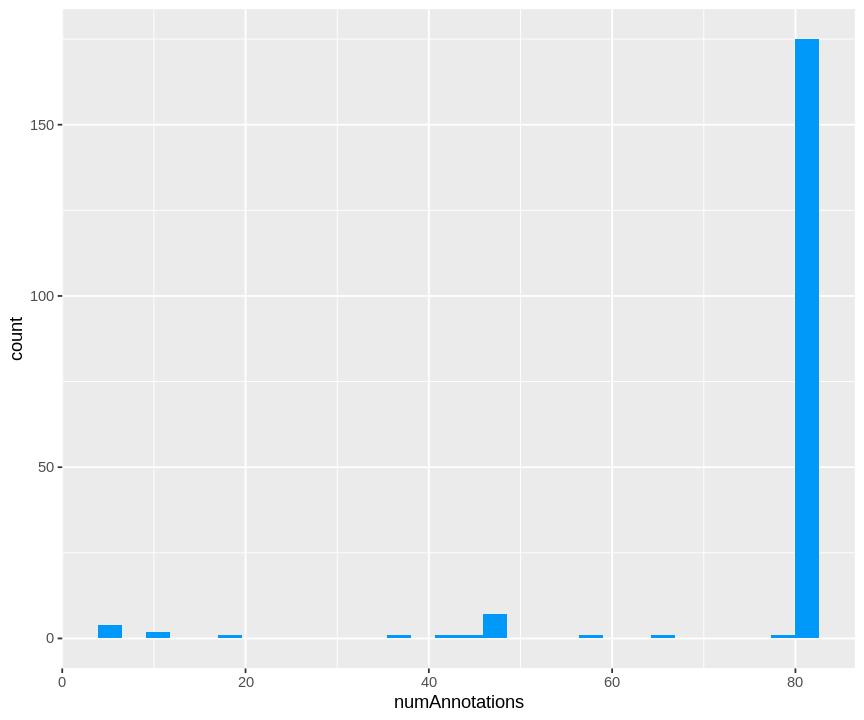

In [ ]:
# Descriptive statistics
ggplot(FeedbackF1Scores, aes(x = numAnnotations)) +
  geom_histogram(fill = "#0099f9", bins = 30)

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


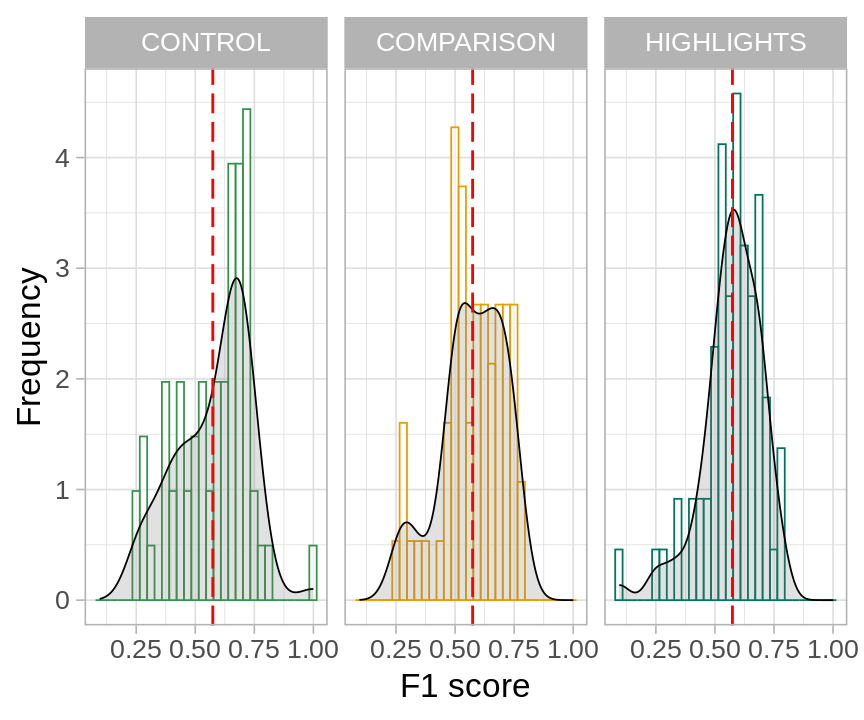

In [ ]:
FeedbackF1Scores %>%
    mutate(feedbackMechanism = factor(feedbackMechanism, levels = c("CONTROL", "COMPARISON", "HIGHLIGHTS"))) %>%

ggplot(., aes(x = f1)) +
  scale_color_manual(values=c("#37924E", "#E69F00", "#007462")) +
  geom_histogram(aes(y = ..density.., color = feedbackMechanism), # the histogram will display "density" on its y-axis
                 bins=30, alpha=0.5, fill="white", show.legend = FALSE) +
  geom_density(alpha = .2, fill="#6e6c6b") +
  geom_vline(aes(xintercept = mean(f1, na.rm = T)),
             colour = "red", linetype ="longdash", size = .8) +
  theme_light(base_size = 20) +
  facet_grid(~ feedbackMechanism) +
  labs(x="F1 score", y = "Frequency")

ggsave('/content/plots/f1-distribution.pdf', width=7.2, height=6)


	Shapiro-Wilk normality test

data:  FeedbackF1Scores$f1
W = 0.95894, p-value = 1.943e-05


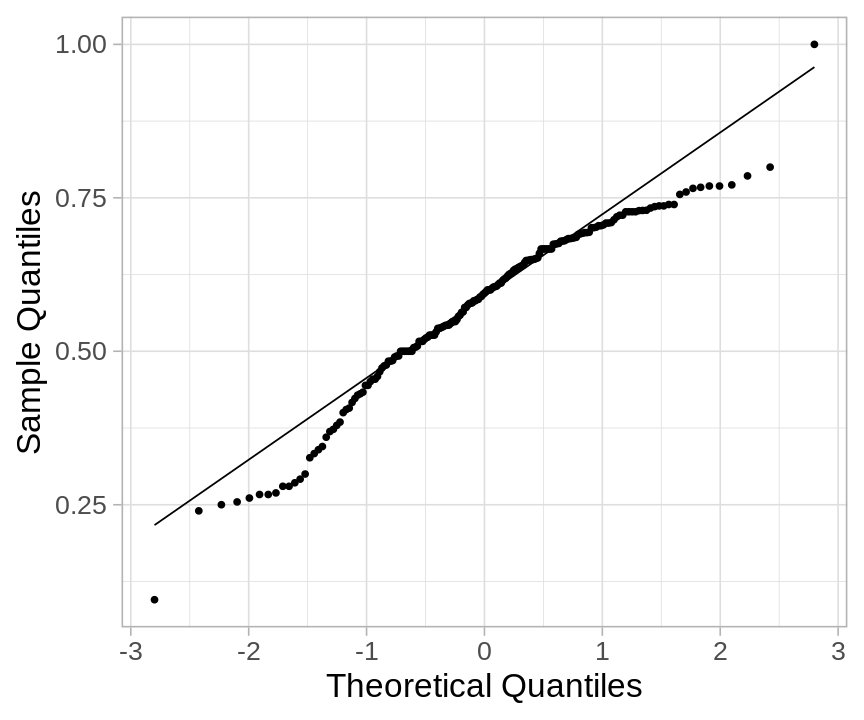

In [ ]:
# Check normal distribution
shapiro.test(FeedbackF1Scores$f1)

ggplot(FeedbackF1Scores, aes(sample=f1)) +
  stat_qq() + 
  stat_qq_line() +
  theme_light(base_size = 20) +
  labs(x="Theoretical Quantiles", y = "Sample Quantiles")

ggsave('/content/plots/f1-qq.pdf', width=7.2, height=6)

Interpretation: Not normally distributed according to Shapiro-Wilk test. Slight negative skew, though according to current research one-way ANOVA is robust to non-normal distributions if the sample size is big (>= 30 participants per group).

In [ ]:
# Equal variances check
leveneTest(f1 ~ feedbackMechanism, data = FeedbackF1Scores)

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,2.311839,0.1018309
,192,NA,NA


Interpretation: Not signficiant, i.e. the variances are equal.

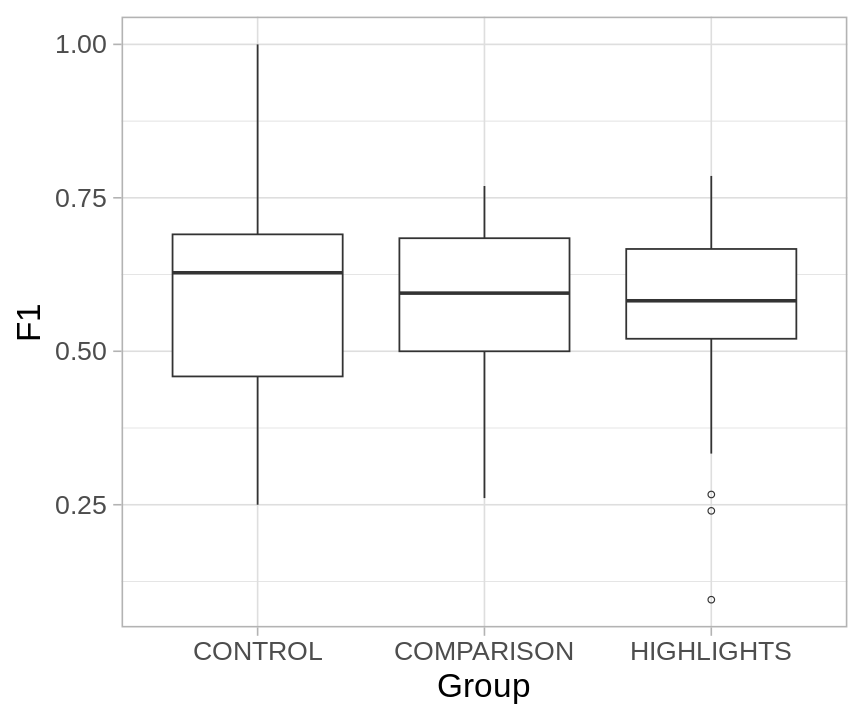

In [ ]:
FeedbackF1Scores %>%
    mutate(feedbackMechanism = factor(feedbackMechanism, levels = c("CONTROL", "COMPARISON", "HIGHLIGHTS"))) %>%

# Boxplots for outliers
ggplot(., aes(x=feedbackMechanism, y=f1)) + 
    geom_boxplot(outlier.shape=1) +
    theme_light(base_size = 20) +
    labs(x="Group", y = "F1")

ggsave('/content/plots/f1-box.pdf', width=7.2, height=6)

In [ ]:
Q1 <- quantile(FeedbackF1Scores$f1, .25)
Q3 <- quantile(FeedbackF1Scores$f1, .75)
IQR <- IQR(FeedbackF1Scores$f1)
up <- Q3+1.5*IQR # Upper Outlier Range  
low <- Q1-1.5*IQR # Lower Outlier Range

Q1
Q3
IQR
low
up

FeedbackF1ScoresNoOutliers <- subset(FeedbackF1Scores, FeedbackF1Scores$f1 > low & FeedbackF1Scores$f1 < up)
nrow(FeedbackF1Scores)
nrow(FeedbackF1ScoresNoOutliers)

25% 
0.5

75% 
0.6798058

[1] 0.1798058

25% 
0.2302913

75% 
0.9495146

[1] 195

[1] 193

Interpretation: Only outliers in the HIGHLIGHTS group, though these are real outliers, as they are not a result of a bad study design. We decide to keep these outliers and report the results with outliers.

In [ ]:
# Standard ANOVA & Tukey's HSD post-hoc test
one.way <- aov(f1 ~ feedbackMechanism, data = FeedbackF1Scores)
summary(one.way)
TukeyHSD(one.way)

# Means
aggregate(f1 ~ feedbackMechanism, data = FeedbackF1Scores, function(x) c(mean = mean(x), sd = sd(x)))

                   Df Sum Sq  Mean Sq F value Pr(>F)
feedbackMechanism   2  0.001 0.000424   0.022  0.978
Residuals         192  3.735 0.019451               

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = f1 ~ feedbackMechanism, data = FeedbackF1Scores)

$feedbackMechanism
                              diff         lwr        upr     p adj
CONTROL-COMPARISON     0.003298637 -0.05567763 0.06227490 0.9904243
HIGHLIGHTS-COMPARISON -0.001649629 -0.05960606 0.05630680 0.9975111
HIGHLIGHTS-CONTROL    -0.004948266 -0.06169172 0.05179519 0.9768849


feedbackMechanism,f1
<chr>,"<dbl[,2]>"
COMPARISON,"0.5736248, 0.1339415"
CONTROL,"0.5769235, 0.1566276"
HIGHLIGHTS,"0.5719752, 0.1266062"


Interpretation:

ANOVA: Feedback mechanism does NOT have a statistically significant effect on F1 score, as indicated by high p-value.

Tukey: (Not even relevant, don't report) No significant difference between the groups.

Means: Almost the same

Summary: No difference

### F1 score and time

In [ ]:
F1ScoresAndTimes <- merge(ParticipantArticleTimes, FeedbackF1Scores, by = "participantId")


Call:
lm(formula = f1 ~ articleTime, data = F1ScoresAndTimesHighlights)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.47130 -0.06698  0.01593  0.08384  0.21495 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 5.127e-01  3.436e-02  14.923   <2e-16 ***
articleTime 1.209e-04  6.324e-05   1.912   0.0601 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1242 on 68 degrees of freedom
Multiple R-squared:  0.051,	Adjusted R-squared:  0.03704 
F-statistic: 3.654 on 1 and 68 DF,  p-value: 0.06014


`geom_smooth()` using formula = 'y ~ x'


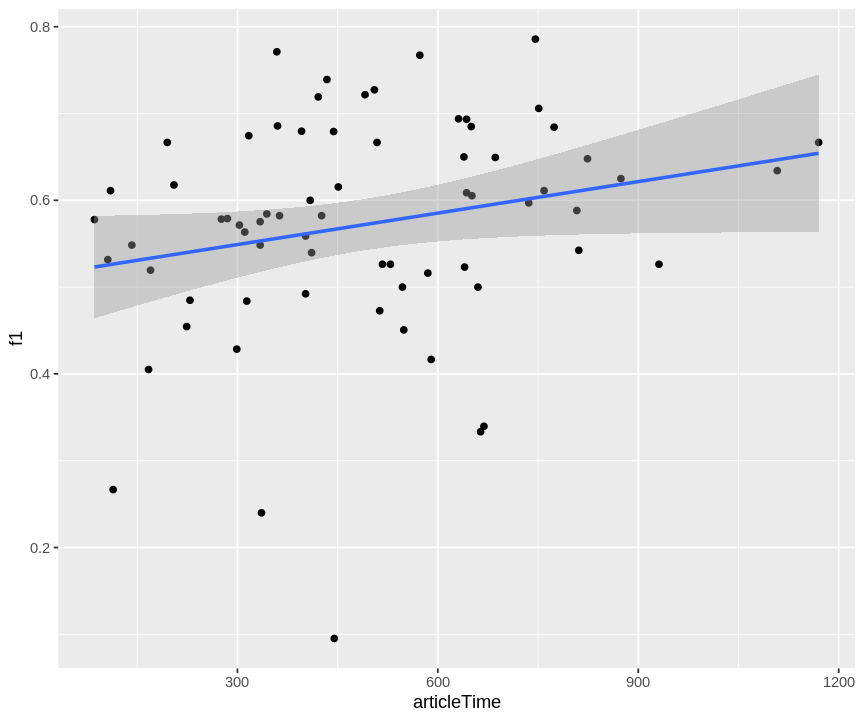

In [ ]:
F1ScoresAndTimesHighlights <- F1ScoresAndTimes %>% filter(feedbackMechanism == "HIGHLIGHTS")

model <- lm(f1 ~ articleTime, data = F1ScoresAndTimesHighlights)
summary(model)

ggplot(F1ScoresAndTimesHighlights, aes(x = articleTime, y = f1)) +
  geom_point() +
  stat_smooth(method = lm)


Call:
lm(formula = f1 ~ articleTime, data = F1ScoresAndTimesComparison)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.30463 -0.08067  0.01582  0.11303  0.19618 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  6.060e-01  3.561e-02  17.020   <2e-16 ***
articleTime -5.065e-05  4.867e-05  -1.041    0.302    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1338 on 58 degrees of freedom
Multiple R-squared:  0.01833,	Adjusted R-squared:  0.001406 
F-statistic: 1.083 on 1 and 58 DF,  p-value: 0.3023


`geom_smooth()` using formula = 'y ~ x'


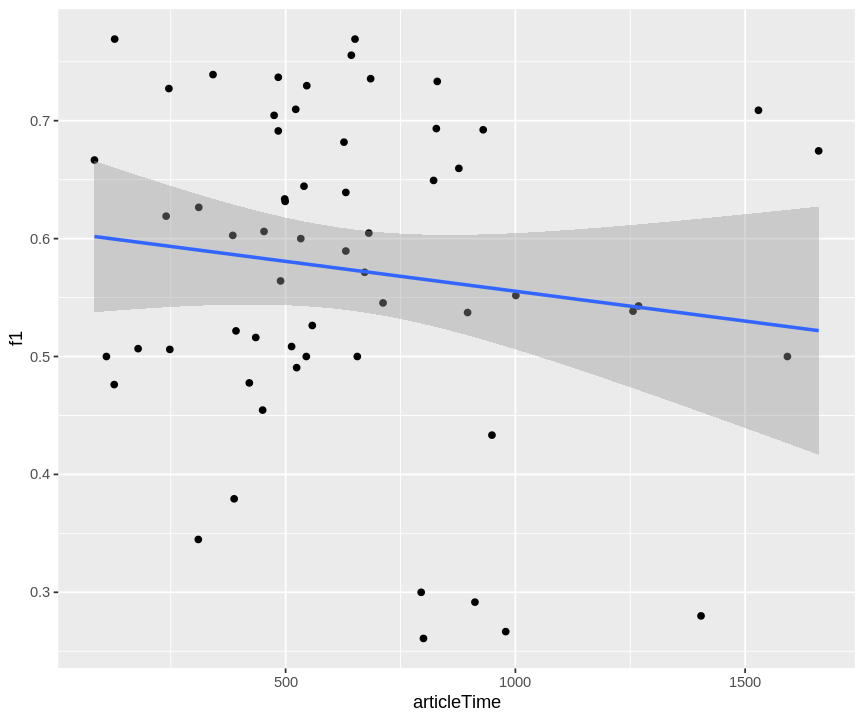

In [ ]:
F1ScoresAndTimesComparison <- F1ScoresAndTimes %>% filter(feedbackMechanism == "COMPARISON")

model <- lm(f1 ~ articleTime, data = F1ScoresAndTimesComparison)
summary(model)

ggplot(F1ScoresAndTimesComparison, aes(x = articleTime, y = f1)) +
  geom_point() +
  stat_smooth(method = lm)


Call:
lm(formula = f1 ~ articleTime, data = F1ScoresAndTimesControl)

Residuals:
    Min      1Q  Median      3Q     Max 
-0.3275 -0.1178  0.0501  0.1133  0.4217 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  5.789e-01  3.715e-02  15.583   <2e-16 ***
articleTime -3.994e-06  6.428e-05  -0.062    0.951    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.1579 on 63 degrees of freedom
Multiple R-squared:  6.129e-05,	Adjusted R-squared:  -0.01581 
F-statistic: 0.003861 on 1 and 63 DF,  p-value: 0.9506


`geom_smooth()` using formula = 'y ~ x'


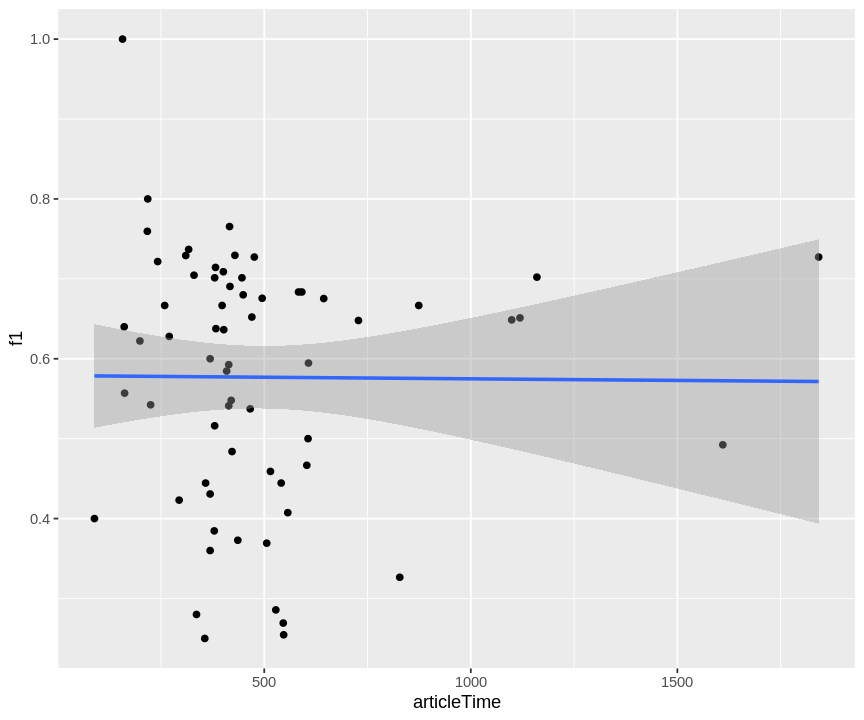

In [ ]:
F1ScoresAndTimesControl <- F1ScoresAndTimes %>% filter(feedbackMechanism == "CONTROL")

model <- lm(f1 ~ articleTime, data = F1ScoresAndTimesControl)
summary(model)

ggplot(F1ScoresAndTimesControl, aes(x = articleTime, y = f1)) +
  geom_point() +
  stat_smooth(method = lm)

 ### Efficiency

Efficiency is just how many annotations were made in which time.

Performance efficiency accounts for the performance by multiplying the efficiency with the F1 score.

In [ ]:
# Efficiency: numAnnotations / articleTime
F1ScoresAndTimes$efficiency <- F1ScoresAndTimes$numAnnotations / F1ScoresAndTimes$articleTime

min(F1ScoresAndTimes$efficiency)
max(F1ScoresAndTimes$efficiency)                                      

# PerformanceEfficiency
F1ScoresAndTimes$performanceEfficiency <- as.numeric(F1ScoresAndTimes$efficiency * F1ScoresAndTimes$f1)

min(F1ScoresAndTimes$performanceEfficiency)
max(F1ScoresAndTimes$performanceEfficiency)

[1] 0.02752294

[1] 0.9534884

[1] 0.01635328

[1] 0.5509044

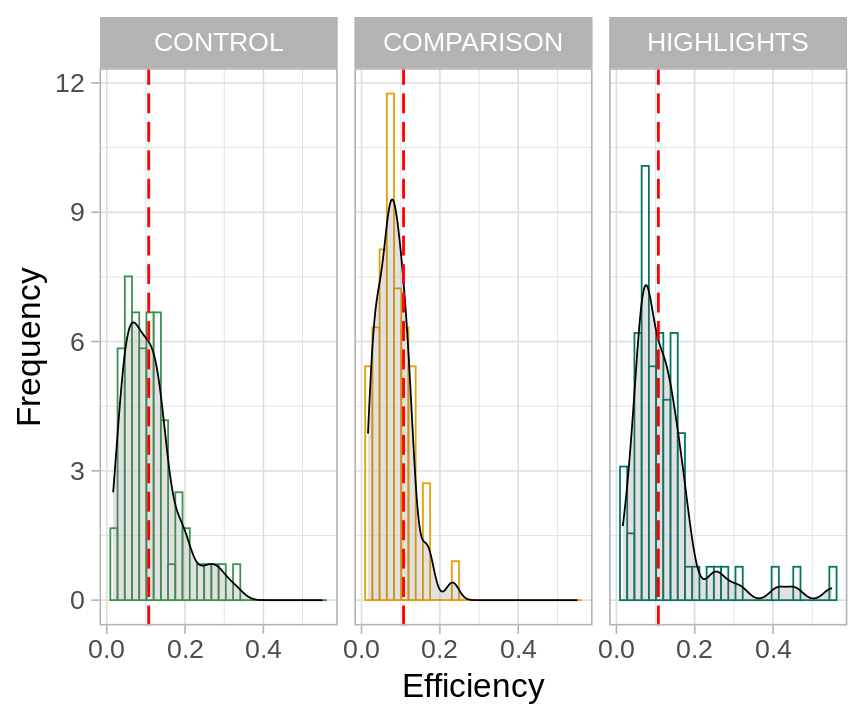

In [ ]:
F1ScoresAndTimes %>%
    mutate(feedbackMechanism = factor(feedbackMechanism, levels = c("CONTROL", "COMPARISON", "HIGHLIGHTS"))) %>%

ggplot(., aes(x = performanceEfficiency)) +
  scale_color_manual(values=c("#37924E", "#E69F00", "#007462")) +
  geom_histogram(aes(y = ..density.., color = feedbackMechanism), # the histogram will display "density" on its y-axis
                 bins=30, alpha=0.5, fill="white", show.legend = FALSE) +
  geom_density(alpha = .2, fill="#6e6c6b") +
  geom_vline(aes(xintercept = mean(performanceEfficiency, na.rm = T)),
             colour = "red", linetype ="longdash", size = .8) +
  theme_light(base_size = 20) +
  facet_grid(~ feedbackMechanism) +
  labs(x="Efficiency", y = "Frequency")

ggsave('/content/plots/eff-distribution.pdf', width=7.2, height=6)


	Shapiro-Wilk normality test

data:  F1ScoresAndTimes$performanceEfficiency
W = 0.79882, p-value = 4.05e-15


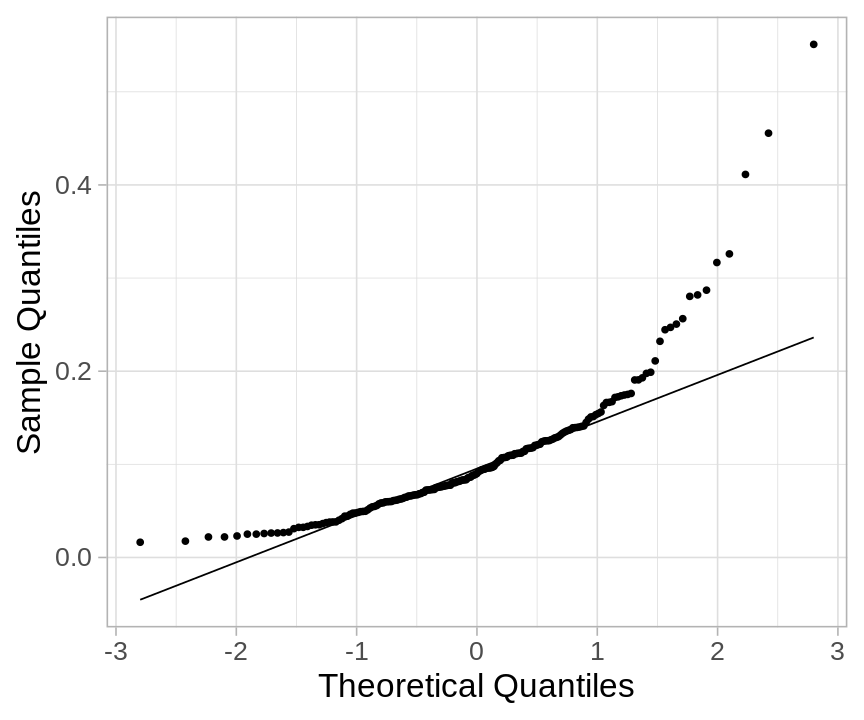

In [ ]:
# Check normal distribution
shapiro.test(F1ScoresAndTimes$performanceEfficiency)

ggplot(F1ScoresAndTimes, aes(sample=performanceEfficiency)) +
  stat_qq() + 
  stat_qq_line() +
  theme_light(base_size = 20) +
  labs(x="Theoretical Quantiles", y = "Sample Quantiles")

ggsave('/content/plots/eff-qq.pdf', width=7.2, height=6)

Interpretation: Not normally distributed according to Shapiro-Wilk test. Slight positive skew, though according to current research one-way ANOVA is robust to non-normal distributions if the sample size is big (>= 30 participants per group).

In [ ]:
# Equal variances check
leveneTest(performanceEfficiency ~ feedbackMechanism, data = F1ScoresAndTimes)

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,3.960137,0.02063771
,192,NA,NA


Interpretation: Significant (p < 0.05), so the variances are not equal => Welch anova

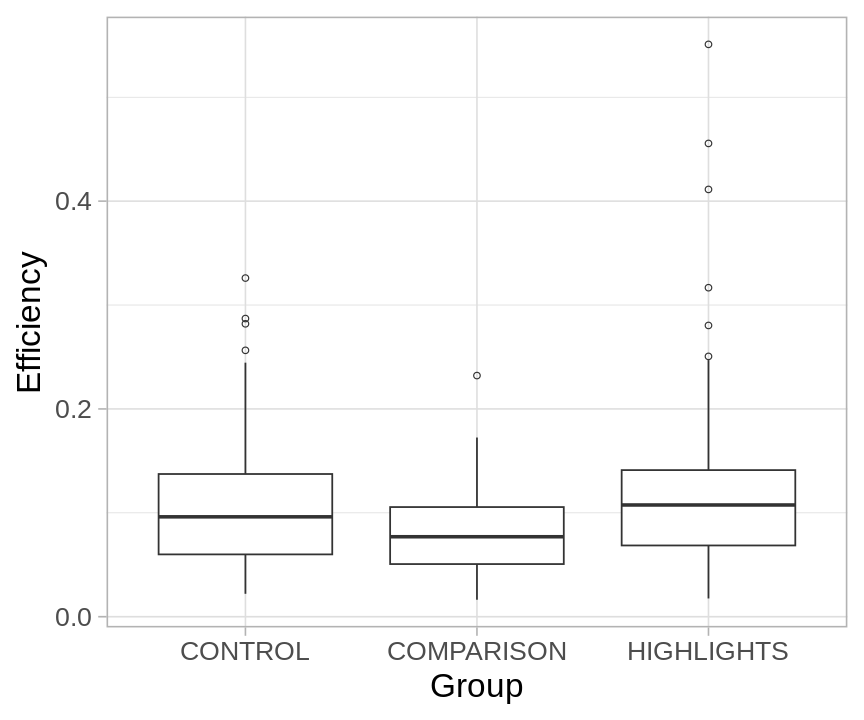

In [ ]:
F1ScoresAndTimes %>%
    mutate(feedbackMechanism = factor(feedbackMechanism, levels = c("CONTROL", "COMPARISON", "HIGHLIGHTS"))) %>%

# Boxplots for outliers
ggplot(., aes(x=feedbackMechanism, y=performanceEfficiency)) + 
    geom_boxplot(outlier.shape=1) +
    theme_light(base_size = 20) +
    labs(x="Group", y = "Efficiency")

ggsave('/content/plots/eff-box.pdf', width=7.2, height=6)

In [ ]:
Q1 <- quantile(F1ScoresAndTimes$performanceEfficiency, .25)
Q3 <- quantile(F1ScoresAndTimes$performanceEfficiency, .75)
IQR <- IQR(F1ScoresAndTimes$performanceEfficiency)
up <- Q3+1.5*IQR # Upper Outlier Range  
low <- Q1-1.5*IQR # Lower Outlier Range

Q1
Q3
IQR
low
up

F1ScoresAndTimesNoOutliers <- subset(F1ScoresAndTimes, F1ScoresAndTimes$performanceEfficiency > low & F1ScoresAndTimes$performanceEfficiency < up)
nrow(F1ScoresAndTimes)
nrow(F1ScoresAndTimesNoOutliers)

25% 
0.06151711

75% 
0.1293719

[1] 0.06785481

25% 
-0.0402651

75% 
0.2311541

[1] 195

[1] 182

Interpretation: Outliers in all group, though mostly in the HIGHLIGHTS group, though these are real outliers, as they are not a result of a bad study design. We decide to keep these outliers.

In [ ]:
# Welch's ANOVA & Games-Howell post-hoc test
oneway.test(performanceEfficiency ~ feedbackMechanism, data = F1ScoresAndTimes, var.equal = FALSE)
games_howell_test(F1ScoresAndTimes, performanceEfficiency ~ feedbackMechanism, detailed = TRUE)

# Means
aggregate(performanceEfficiency ~ feedbackMechanism, data = F1ScoresAndTimes, function(x) c(mean = mean(x), sd = sd(x)))


	One-way analysis of means (not assuming equal variances)

data:  performanceEfficiency and feedbackMechanism
F = 8.5977, num df = 2.00, denom df = 120.89, p-value = 0.0003227


,.y.,group1,group2,n1,n2,estimate,conf.low,conf.high,se,statistic,df,p.adj,p.adj.signif,method
,<chr>,<chr>,<chr>,<int[1d]>,<int[1d]>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,performanceEfficiency,COMPARISON,CONTROL,60,65,0.03030153,0.006490722,0.05411235,0.007085006,3.0241923,108.19993,0.009,**,Games-Howell
2,performanceEfficiency,COMPARISON,HIGHLIGHTS,60,70,0.04390635,0.013909568,0.07390314,0.008913020,3.4832726,98.20017,0.002,**,Games-Howell
3,performanceEfficiency,CONTROL,HIGHLIGHTS,65,70,0.01360482,-0.019945531,0.04715517,0.010001614,0.9618508,124.88340,0.602,ns,Games-Howell


feedbackMechanism,performanceEfficiency
<chr>,"<dbl[,2]>"
COMPARISON,"0.08129679, 0.04214756"
CONTROL,"0.11159832, 0.06783213"
HIGHLIGHTS,"0.12520314, 0.09512825"


Interpretation:

ANOVA: Feedback mechanism DOES have a statistically significant effect on performance efficiency (p < 0.001).

Games-Howell post-hoc: Significant differences between the means of COMPARISON and CONTROL and the means of COMPARISON and HIGHLIGHTS (p < 0.01).

Means: COMPARISON < CONTROL < HIGHLIGHTS

Summary: COMPARISON worse than CONTROL and HIGHLIGHTS => HIGHLIGHTS

### Engagement

In [ ]:
totalSentences <- nrow(Content)

FeedbackEngagement <- Feedback %>%
  group_by(participantId) %>%
  summarize(
    engagement = n() / totalSentences,
    feedbackMechanism = feedbackMechanism,
    numAnnotations = n()
  ) %>%
  slice(1)

totalSentences
nrow(FeedbackEngagement)

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'participantId'. You can override using the
`.groups` argument.


[1] 84

[1] 206

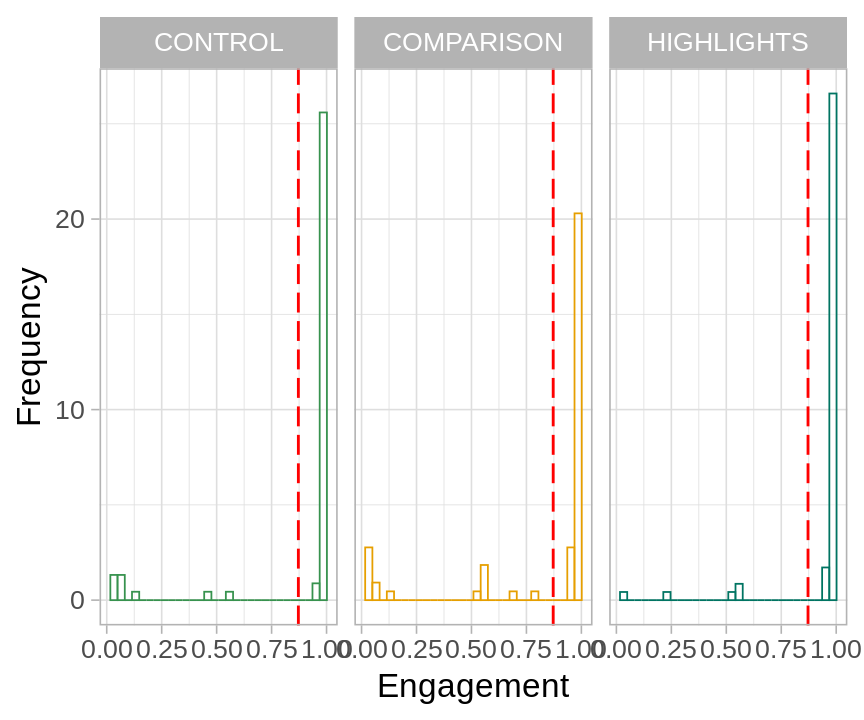

In [ ]:
FeedbackEngagement %>%
    mutate(feedbackMechanism = factor(feedbackMechanism, levels = c("CONTROL", "COMPARISON", "HIGHLIGHTS"))) %>%

ggplot(., aes(x = engagement)) +
  scale_color_manual(values=c("#37924E", "#E69F00", "#007462")) +
  geom_histogram(aes(y = ..density.., color = feedbackMechanism), # the histogram will display "density" on its y-axis
                 bins=30, alpha=0.5, fill="white", show.legend = FALSE) +
  geom_vline(aes(xintercept = mean(engagement, na.rm = T)),
             colour = "red", linetype ="longdash", size = .8) +
  theme_light(base_size = 20) +
  facet_grid(~ feedbackMechanism) +
  labs(x="Engagement", y = "Frequency")

ggsave('/content/plots/eng-distribution.pdf', width=7.2, height=6)


	Shapiro-Wilk normality test

data:  FeedbackEngagement$engagement
W = 0.42751, p-value < 2.2e-16


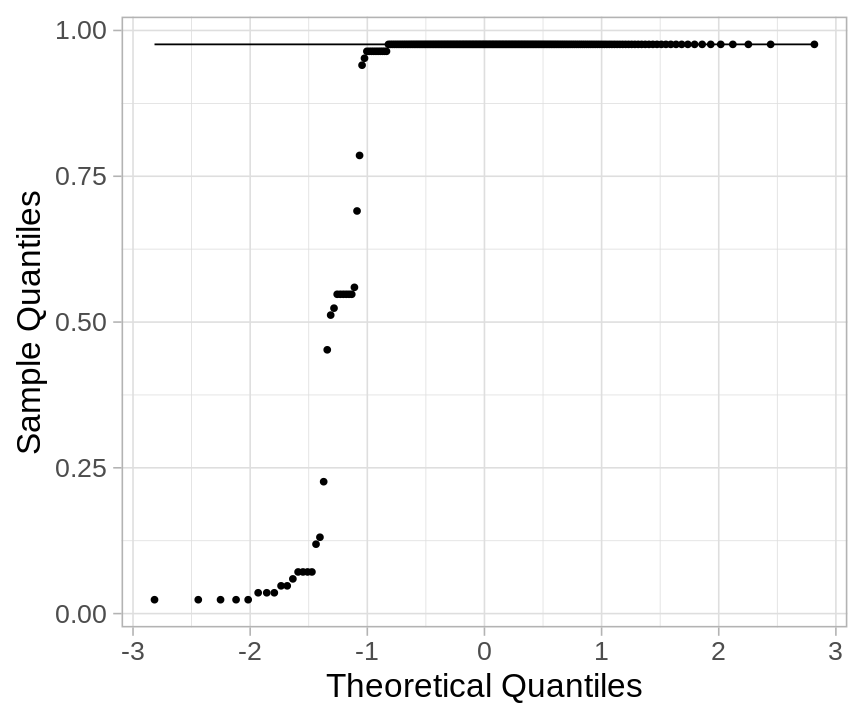

In [ ]:
# Check normal distribution
shapiro.test(FeedbackEngagement$engagement)

ggplot(FeedbackEngagement, aes(sample=engagement)) +
  stat_qq() + 
  stat_qq_line() +
  theme_light(base_size = 20) +
  labs(x="Theoretical Quantiles", y = "Sample Quantiles")

ggsave('/content/plots/eng-qq.pdf', width=7.2, height=6)

Interpretation: Not normally distributed according to Shapiro-Wilk test.

In [ ]:
# Equal variances check
leveneTest(engagement ~ feedbackMechanism, data = FeedbackEngagement)

Warning message in leveneTest.default(y = y, group = group, ...):
“group coerced to factor.”


,Df,F value,Pr(>F)
,<int>,<dbl>,<dbl>
group,2,3.731384,0.0256187
,203,NA,NA


Interpretation: Not equal variance => Welch's ANOVA

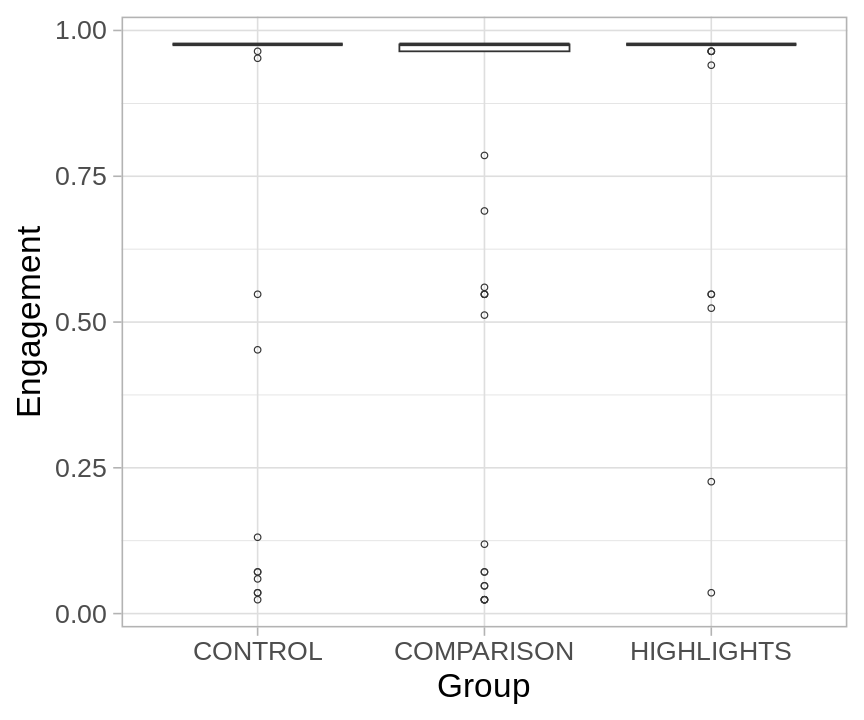

In [ ]:
FeedbackEngagement %>%
    mutate(feedbackMechanism = factor(feedbackMechanism, levels = c("CONTROL", "COMPARISON", "HIGHLIGHTS"))) %>%

# Boxplots for outliers
ggplot(., aes(x=feedbackMechanism, y=engagement)) + 
    geom_boxplot(outlier.shape=1) +
    theme_light(base_size = 20) +
    labs(x="Group", y = "Engagement")

ggsave('/content/plots/eng-box.pdf', width=7.2, height=6)

In [ ]:
Q1 <- quantile(FeedbackEngagement$engagement, .25)
Q3 <- quantile(FeedbackEngagement$engagement, .75)
IQR <- IQR(FeedbackEngagement$engagement)
up <- Q3+1.5*IQR # Upper Outlier Range  
low <- Q1-1.5*IQR # Lower Outlier Range

Q1
Q3
IQR
low
up

FeedbackEngagementNoOutliers <- subset(FeedbackEngagement, FeedbackEngagement$engagement < up)
dim(FeedbackEngagement)
dim(FeedbackEngagementNoOutliers)

25% 
0.9761905

75% 
0.9761905

[1] 0

25% 
0.9761905

75% 
0.9761905

[1] 206   4

[1] 42  4

Interpretation: Outliers in all groups, though these are real outliers, as they are not a result of a bad study design. We decide to keep these outliers and report the results with outliers. (Argument: some people just didn't annotate a lot of sentences but these are natural outliers and what we want to test)

In [ ]:
# Welch's ANOVA & Games-Howell post-hoc test
oneway.test(engagement ~ feedbackMechanism, data = FeedbackEngagement, var.equal = FALSE)
games.howell(FeedbackEngagement$feedbackMechanism, FeedbackEngagement$engagement)

# Means
aggregate(engagement ~ feedbackMechanism, data = FeedbackEngagement, function(x) c(mean = mean(x), sd = sd(x)))


	One-way analysis of means (not assuming equal variances)

data:  engagement and feedbackMechanism
F = 4.3801, num df = 2.00, denom df = 120.27, p-value = 0.01458


groups,Mean Difference,Standard Error,t,df,p,upper limit,lower limit
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
HIGHLIGHTS : CONTROL,-0.064,0.028,1.618,107.970,0.243,0.030,-0.158
HIGHLIGHTS : COMPARISON,-0.124,0.032,2.778,94.304,0.018,-0.018,-0.231
CONTROL : COMPARISON,-0.060,0.037,1.139,128.879,0.492,0.065,-0.186


feedbackMechanism,engagement
<chr>,"<dbl[,2]>"
COMPARISON,"0.8088023, 0.3266192"
CONTROL,"0.8690476, 0.2852909"
HIGHLIGHTS,"0.9329309, 0.1642221"


Interpretation:

ANOVA: Feedback mechanism DOES have a statistically significant effect on engagement (p < 0.05).

Games-Howell post-hoc: Significant differences between the means of COMPARISON and HIGHLIGHTS (p < 0.05).

Means: COMPARISON < CONTROL < HIGHLIGHTS

Summary: COMPARISON worse than HIGHLIGHTS => HIGHLIGHTS

### Inter-rater-reliability

In [ ]:
# pivot the dataframe to create one column for each participant
df_wide <- FeedbackOnlyHighlights %>%
  select(contentId, participantId, biasedParticipant) %>%
  pivot_wider(id_cols = participantId, names_from = contentId, values_from = biasedParticipant)

df_no_contentids <- select(df_wide, -participantId)
df_matrix <- as.matrix(df_no_contentids)

# calculate Krippendorff's alpha
krippendorff_alpha <- kripp.alpha(df_matrix, method = "nominal")

# Fleiss' kappa eliminates missing values but we have a lot so not applicable

# view the results
print(krippendorff_alpha)

 Krippendorff's alpha

 Subjects = 82 
   Raters = 71 
    alpha = 0.229 


In [ ]:
# pivot the dataframe to create one column for each participant
df_wide <- FeedbackOnlyComparison %>%
  select(contentId, participantId, biasedParticipant) %>%
  pivot_wider(id_cols = participantId, names_from = contentId, values_from = biasedParticipant)

df_no_contentids <- select(df_wide, -participantId)
df_matrix <- as.matrix(df_no_contentids)

# calculate Krippendorff's alpha
krippendorff_alpha <- kripp.alpha(df_matrix, method = "nominal")

# Fleiss' kappa eliminates missing values but we have a lot so not applicable

# view the results
print(krippendorff_alpha)

 Krippendorff's alpha

 Subjects = 82 
   Raters = 66 
    alpha = 0.2 


In [ ]:
# pivot the dataframe to create one column for each participant
df_wide <- FeedbackOnlyControl %>%
  select(contentId, participantId, biasedParticipant) %>%
  pivot_wider(id_cols = participantId, names_from = contentId, values_from = biasedParticipant)

df_no_contentids <- select(df_wide, -participantId)
df_matrix <- as.matrix(df_no_contentids)

# calculate Krippendorff's alpha
krippendorff_alpha <- kripp.alpha(df_matrix, method = "nominal")

# Fleiss' kappa eliminates missing values but we have a lot so not applicable

# view the results
print(krippendorff_alpha)

 Krippendorff's alpha

 Subjects = 82 
   Raters = 69 
    alpha = 0.22 
